In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import os
import shutil
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing import image
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
import cv2
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

# Image recognition of grocery products

## 1. Analysis

### 1.1 Project Description 

This project aims to develop a machine learning model capable of identifying grocery products and categorizing them based on their images. The model will analyze product images to classify items such as fruits, vegetables, beverages, and packaged goods into predefined categories. 

### 1.2 Business Objective Definition

Our solution aims to enhance Stibo Systems' Master Data Management (MDM) capabilities by integrating advanced image recognition technology to automatically identify and categorize customer products based on images provided by their clients. This innovation will streamline product classification processes, ensuring greater accuracy and efficiency. By empowering Stibo Systems to offer a more intelligent and automated approach to product data management, the solution supports practical use cases such as improved inventory management, retail automation, and enhanced consumer convenience, while also enabling applications like automatic checkout, product cataloging, and stock monitoring. 

### 1.3 Framing the problem
The problem is a supervised learning classification task, where the model takes a picture of a grocery item, identifies it and maps it into its category. Labeled datasets containing images and corresponding category labels are used to train the model. A classification model would seem like a good fit for classifying an image to the item’s name and category. 

The target audience includes Stibo Systems and their clients, who rely on accurate and automated product categorization for harmonizing data across multiple sources in their MDM-systems. While the initial focus is on grocery products, the ultimate goal is to develop a scalable solution that can extend to any product category, providing a versatile tool for data management needs. 


### 1.4 Performance Metrics 

In our project, we will evaluate the performance of the model using a combination of precision, recall, F1-score, and top-k accuracy to ensure a comprehensive assessment of its effectiveness in identifying and categorizing grocery products. 

- Precision will measure the proportion of correctly predicted products in each category out of all predictions for that category. This metric is essential to minimize false positives, ensuring that incorrect categorizations are kept to a minimum. 

- Recall will assess the proportion of correctly identified products in each category out of all actual products in that category. This is particularly important to ensure that the model does not miss relevant products, especially in scenarios where accurate categorization is critical for downstream processes. 

- F1-Score, the harmonic mean of precision and recall, will serve as the primary metric for overall model performance. It provides a balanced measure, particularly useful in scenarios where there is a need to optimize both precision and recall, such as handling imbalanced categories or avoiding bias toward dominant product types. 

- Top-k Accuracy will measure whether the correct category appears within the top-k predictions. This metric is particularly relevant for real-world applications like auto-checkout or cataloging, where the system can suggest multiple likely categories for verification, ensuring practical usability even when the top prediction is incorrect. 

By combining these metrics, we will gain a holistic understanding of the model’s performance and ensure it meets both technical and business requirements effectively. 

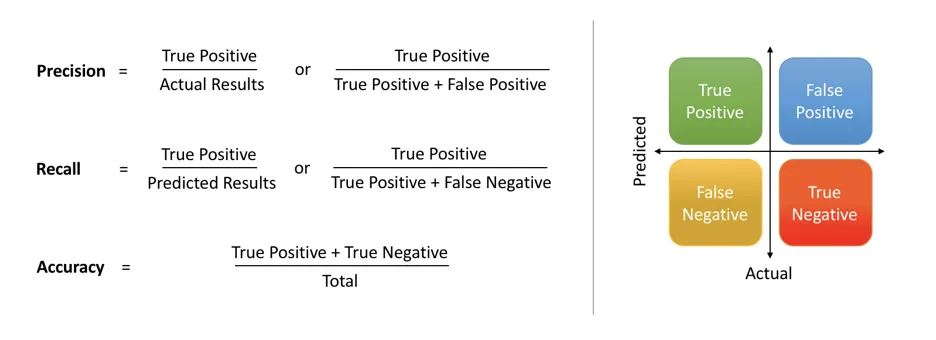

## 2. Data exploration

### 2.1 Data source 

Data for this assignment was found using <a href="https://www.kaggle.com/datasets/amoghmisra27/grocery/data">Kaggle</a>.

### 2.2 Get the data

In [ ]:
# Loading datasets
classes = pd.read_csv('GroceryStoreDataset-master/dataset/classes.csv')
classes.head()

Class Name (str)  Class ID (int) Coarse Class Name (str)  \
0  Golden-Delicious               0                   Apple   
1      Granny-Smith               1                   Apple   
2         Pink-Lady               2                   Apple   
3     Red-Delicious               3                   Apple   
4        Royal-Gala               4                   Apple   

   Coarse Class ID (int)                            Iconic Image Path (str)  \
0                      0  /iconic-images-and-descriptions/Fruit/Apple/Go...   
1                      0  /iconic-images-and-descriptions/Fruit/Apple/Gr...   
2                      0  /iconic-images-and-descriptions/Fruit/Apple/Pi...   
3                      0  /iconic-images-and-descriptions/Fruit/Apple/Re...   
4                      0  /iconic-images-and-descriptions/Fruit/Apple/Ro...   

                      Product Description Path (str)  
0  /iconic-images-and-descriptions/Fruit/Apple/Go...  
1  /iconic-images-and-descriptions/Fruit/Apple/Gr...  
2  /iconic-images-and-descriptions/Fruit/Apple/Pi...  
3  /iconic-images-and-descriptions/Fruit/Apple/Re...  
4  /iconic-images-and-descriptions/Fruit/Apple/Ro...

In [70]:
classes['Coarse Class Name (str)'].unique()

array(['Apple', 'Avocado', 'Banana', 'Kiwi', 'Lemon', 'Lime', 'Mango',
       'Melon', 'Nectarine', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach',
       'Pear', 'Pineapple', 'Plum', 'Pomegranate', 'Red-Grapefruit',
       'Satsumas', 'Juice', 'Milk', 'Oatghurt', 'Oat-Milk', 'Sour-Cream',
       'Sour-Milk', 'Soyghurt', 'Soy-Milk', 'Yoghurt', 'Asparagus',
       'Aubergine', 'Cabbage', 'Carrots', 'Cucumber', 'Garlic', 'Ginger',
       'Leek', 'Mushroom', 'Onion', 'Pepper', 'Potato', 'Red-Beet',
       'Tomato', 'Zucchini'], dtype=object)

### 2.3 Size and type of data
The dataset contains natural images of grocery items. All natural images were taken with a smartphone camera in different grocery stores. There are 5125 natural images from 81 different classes of fruits, vegetables, and carton items. The 81 classes are divided into 42 coarse-grained classes, where e.g. the fine-grained classes 'Royal Gala' and 'Granny Smith' belong to the same coarse-grained class 'Apple'.

The dataset contains images predominantly in JPEG format, with dimensions of 348x348 pixels, and utilizing the RGB color mode. These images are organized into subdirectories based on categories, such as "iconic" images representing the products. The consistent image size and format simplify preprocessing and model training, while the structured organization aids in efficient data management and category-specific analysis. 

The dataset is divided into three subsets: 

    Training Set: 2640 images 

    Validation Set: 296 images 

    Test Set: 2485 images 

This distribution of image samples introduces some concerns:
- Imbalanced data distribution: The model might not perform optimally due to an insufficiently large training set. Typically, the training set should be the largest portion of the data to allow the model to learn as comprehensively as possible.
- Overfitting or Underfitting: With a small validation set, there's a risk that the model's tuning is not reflective of its performance on a broader range of data, leading to overfitting (where the model learns the training data too well, including the noise and errors) or underfitting (where the model does not learn the underlying patterns effectively).
- Wasted Data on Testing: While it is good to have a comprehensive test to evaluate the model, the current allocation might be excessive. Reducing the test set and reallocating those images to the training set could provide more learning opportunities without significantly compromising the model’s evaluation.

Further in section 3, we will explore the image sample distribution within the categories and see how we can optimally redistribute the images.

## 3. Explore the data

1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

### 3.1 Create dataset copies

In [71]:
grocery_items_df = pd.DataFrame(classes)
display(grocery_items_df)

Class Name (str)  Class ID (int) Coarse Class Name (str)  \
0   Golden-Delicious               0                   Apple   
1       Granny-Smith               1                   Apple   
2          Pink-Lady               2                   Apple   
3      Red-Delicious               3                   Apple   
4         Royal-Gala               4                   Apple   
..               ...             ...                     ...   
76          Red-Beet              76                Red-Beet   
77       Beef-Tomato              77                  Tomato   
78    Regular-Tomato              78                  Tomato   
79       Vine-Tomato              79                  Tomato   
80          Zucchini              80                Zucchini   

    Coarse Class ID (int)                            Iconic Image Path (str)  \
0                       0  /iconic-images-and-descriptions/Fruit/Apple/Go...   
1                       0  /iconic-images-and-descriptions/Fruit/Apple/Gr...   
2                       0  /iconic-images-and-descriptions/Fruit/Apple/Pi...   
3                       0  /iconic-images-and-descriptions/Fruit/Apple/Re...   
4                       0  /iconic-images-and-descriptions/Fruit/Apple/Ro...   
..                    ...                                                ...   
76                     40  /iconic-images-and-descriptions/Vegetables/Red...   
77                     41  /iconic-images-and-descriptions/Vegetables/Tom...   
78                     41  /iconic-images-and-descriptions/Vegetables/Tom...   
79                     41  /iconic-images-and-descriptions/Vegetables/Tom...   
80                     42  /iconic-images-and-descriptions/Vegetables/Zuc...   

                       Product Description Path (str)  
0   /iconic-images-and-descriptions/Fruit/Apple/Go...  
1   /iconic-images-and-descriptions/Fruit/Apple/Gr...  
2   /iconic-images-and-descriptions/Fruit/Apple/Pi...  
3   /iconic-images-and-descriptions/Fruit/Apple/Re...  
4   /iconic-images-and-descriptions/Fruit/Apple/Ro...  
..                                                ...  
76  /iconic-images-and-descriptions/Vegetables/Red...  
77  /iconic-images-and-descriptions/Vegetables/Tom...  
78  /iconic-images-and-descriptions/Vegetables/Tom...  
79  /iconic-images-and-descriptions/Vegetables/Tom...  
80  /iconic-images-and-descriptions/Vegetables/Zuc...  

[81 rows x 6 columns]

### 3.2 Features and their characteristics

In [72]:
grocery_items_df.columns

Index(['Class Name (str)', 'Class ID (int)', 'Coarse Class Name (str)',
       'Coarse Class ID (int)', 'Iconic Image Path (str)',
       'Product Description Path (str)'],
      dtype='object')

In the output above, we can see that there are 6 features:
- Class Name (str) - e.g. 'Golden-Delicious', 'Pink-Lady'
- Class ID (int) - 0 to 80, as there are 81 classes
- Coarse Class Name (str) - e.g. 'Apple', 'Tomato' - category for each class
- Coarse Class ID (int) - 0 to 42, as there are 43 coarse classes
- Iconic Image Path (str) - file path to the picture in JPG format
- Product Description Path (str) - filepath to the grocery product's description in txt file

To make the features more understandable, we rename 'Coarse Class Name (str)' to 'Category Name (str)' and 'Coarse Class ID (int)' to 'Category ID (int)'


In [ ]:
# rename column 'Coarse Class Name (str)' to 'Category Name'
grocery_items_df.rename(columns = {'Coarse Class Name (str)':'Category Name (str)'}, inplace = True)
grocery_items_df.rename(columns = {'Coarse Class ID (int)':'Category ID (int)'}, inplace = True)
display(grocery_items_df)

Class Name (str)  Class ID (int) Category Name (str)  Category ID (int)  \
0   Golden-Delicious               0               Apple                  0   
1       Granny-Smith               1               Apple                  0   
2          Pink-Lady               2               Apple                  0   
3      Red-Delicious               3               Apple                  0   
4         Royal-Gala               4               Apple                  0   
..               ...             ...                 ...                ...   
76          Red-Beet              76            Red-Beet                 40   
77       Beef-Tomato              77              Tomato                 41   
78    Regular-Tomato              78              Tomato                 41   
79       Vine-Tomato              79              Tomato                 41   
80          Zucchini              80            Zucchini                 42   

                              Iconic Image Path (str)  \
0   /iconic-images-and-descriptions/Fruit/Apple/Go...   
1   /iconic-images-and-descriptions/Fruit/Apple/Gr...   
2   /iconic-images-and-descriptions/Fruit/Apple/Pi...   
3   /iconic-images-and-descriptions/Fruit/Apple/Re...   
4   /iconic-images-and-descriptions/Fruit/Apple/Ro...   
..                                                ...   
76  /iconic-images-and-descriptions/Vegetables/Red...   
77  /iconic-images-and-descriptions/Vegetables/Tom...   
78  /iconic-images-and-descriptions/Vegetables/Tom...   
79  /iconic-images-and-descriptions/Vegetables/Tom...   
80  /iconic-images-and-descriptions/Vegetables/Zuc...   

                       Product Description Path (str)  
0   /iconic-images-and-descriptions/Fruit/Apple/Go...  
1   /iconic-images-and-descriptions/Fruit/Apple/Gr...  
2   /iconic-images-and-descriptions/Fruit/Apple/Pi...  
3   /iconic-images-and-descriptions/Fruit/Apple/Re...  
4   /iconic-images-and-descriptions/Fruit/Apple/Ro...  
..                                                ...  
76  /iconic-images-and-descriptions/Vegetables/Red...  
77  /iconic-images-and-descriptions/Vegetables/Tom...  
78  /iconic-images-and-descriptions/Vegetables/Tom...  
79  /iconic-images-and-descriptions/Vegetables/Tom...  
80  /iconic-images-and-descriptions/Vegetables/Zuc...  

[81 rows x 6 columns]

To continue the data exploration, we will check how many items there are per category, to get a better understanding of the scope.

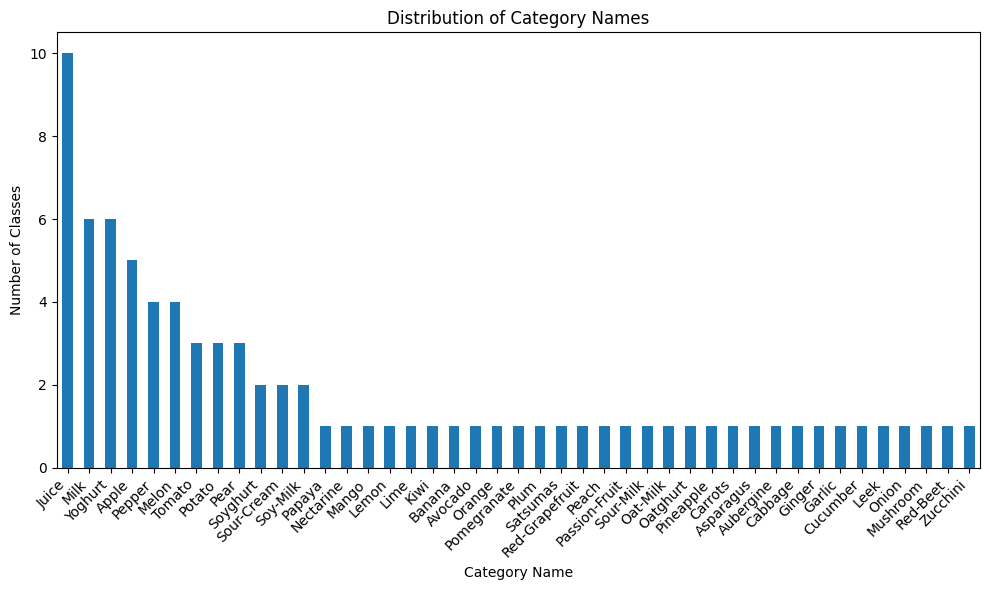

In [74]:
# Count the number of fine-grained classes in each coarse class
category_counts = grocery_items_df["Category Name (str)"].value_counts()

# Plot the distribution of classes in each category
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', title='Distribution of Category Names')
plt.xlabel('Category Name')
plt.ylabel('Number of Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Let's look at how many images there are per class in each train, test, and validation data set. To see this, we randomly choose a category - 'Juice', since it has the most classes.

In [75]:
train_file = 'GroceryStoreDataset-master/dataset/train.txt'
val_file = 'GroceryStoreDataset-master/dataset/val.txt'
test_file = 'GroceryStoreDataset-master/dataset/test.txt'

def count_images_by_classes(file_path, class_list):
    count = 0
    with open(file_path, 'r') as file:
        for line in file:
            image_path = line.strip().split()[0]
            if any(cls in image_path for cls in class_list):
                count += 1
    return count

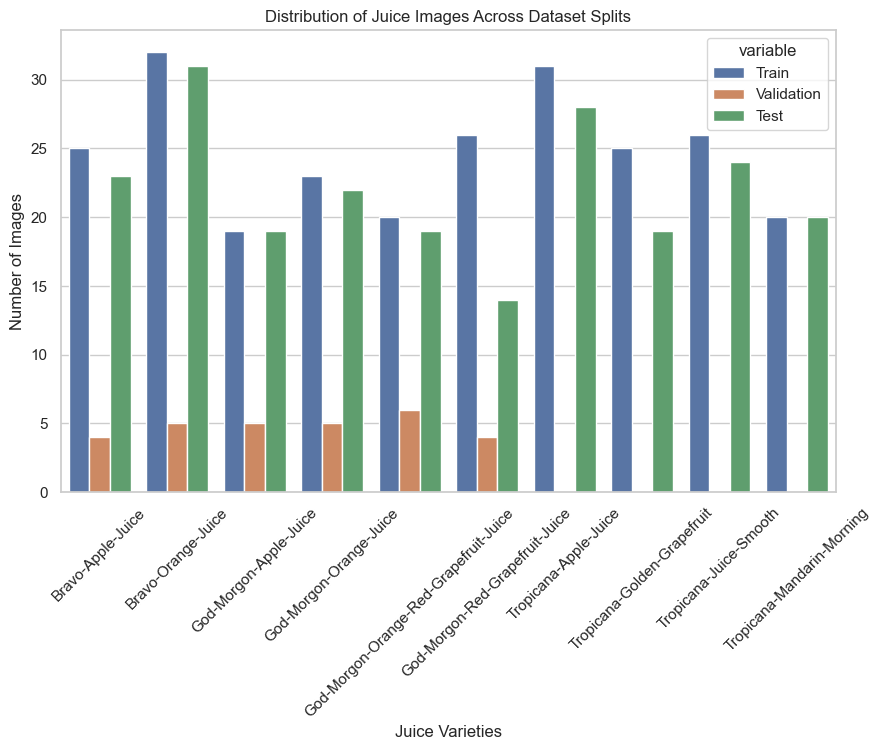

In [76]:
# Filtering for juice-related classes
juice_data = grocery_items_df[grocery_items_df['Category Name (str)'].str.contains("Juice", case=False, na=False)]

# Get unique classes of juices
juice_classes = juice_data['Class Name (str)'].unique()

# Prepare a DataFrame to hold the counts
columns = ['Juice Variety', 'Train', 'Validation', 'Test']
data = []

for juice in juice_classes:
    juice_list = juice_data[juice_data['Class Name (str)'].str.contains(juice, case=False, na=False)]['Class Name (str)'].tolist()

    # Count images for each dataset split
    train_count = count_images_by_classes(train_file, juice_list)
    val_count = count_images_by_classes(val_file, juice_list)
    test_count = count_images_by_classes(test_file, juice_list)

    data.append([juice, train_count, val_count, test_count])

juice_distribution_df = pd.DataFrame(data, columns=columns)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot data
plt.figure(figsize=(10, 6))
juice_plot = sns.barplot(x='Juice Variety', y='value', hue='variable', data=pd.melt(juice_distribution_df, ['Juice Variety']))

# Enhance plot aesthetics
juice_plot.set_title('Distribution of Juice Images Across Dataset Splits')
juice_plot.set_xlabel('Juice Varieties')
juice_plot.set_ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate class labels for better readability

# Show the plot
plt.show()



As we also observed in section 2.3, the image samples aren't optimally distributed, resulting in max 50% for the training set, 6% for the validation set, and 45% for the testing set. 
Our aim is:
- Training Set: About 70-80% of the data (ideally around 3795 to 4337 images).
- Validation Set: About 10-15% of the data (ideally around 542 to 813 images).
- Test Set: About 10-15% of the data (ideally around 542 to 813 images).

Therefore, we will redistribute the samples in each class to ensure following the 60/20/20 rule of dataset distribution.


Restribution of test, validation and train data

In [77]:
from collections import defaultdict
import random
import pandas as pd

all_classes = grocery_items_df['Class Name (str)'].tolist()

# Stratified reallocation function
def stratified_reallocate_splits(train_file, val_file, test_file, class_names, new_train_ratio=0.6, new_val_ratio=0.2, new_test_ratio=0.2):
    # Load the current splits
    with open(train_file, 'r') as f:
        train_data = f.readlines()
    with open(val_file, 'r') as f:
        val_data = f.readlines()
    with open(test_file, 'r') as f:
        test_data = f.readlines()

    # Combine all data
    all_data = train_data + val_data + test_data

    # Group data by categories
    category_data = defaultdict(list)
    for line in all_data:
        for class_name in class_names:
            if class_name in line:
                category_data[class_name].append(line)
                break

    # Create new splits
    new_train_data, new_val_data, new_test_data = [], [], []

    for category, items in category_data.items():
        random.shuffle(items)
        total = len(items)
        train_size = int(total * new_train_ratio)
        val_size = int(total * new_val_ratio)

        new_train_data.extend(items[:train_size])
        new_val_data.extend(items[train_size:train_size + val_size])
        new_test_data.extend(items[train_size + val_size:])

    # Save the new splits to files
    with open('GroceryStoreDataset-working/dataset/train.txt', 'w') as f:
        f.writelines(new_train_data)
    with open('GroceryStoreDataset-working/dataset/val.txt', 'w') as f:
        f.writelines(new_val_data)
    with open('GroceryStoreDataset-working/dataset/test.txt', 'w') as f:
        f.writelines(new_test_data)

    return len(new_train_data), len(new_val_data), len(new_test_data)

# Apply stratified reallocation across all classes
new_train_count, new_val_count, new_test_count = stratified_reallocate_splits(
    train_file, val_file, test_file, all_classes, new_train_ratio=0.6, new_val_ratio=0.2, new_test_ratio=0.2
)

print(f"New Train Count: {new_train_count}")
print(f"New Validation Count: {new_val_count}")
print(f"New Test Count: {new_test_count}")

New Train Count: 3220
New Validation Count: 1055
New Test Count: 1146


Recalculate the distribution of each category in the new splits and compare it with the original distribution to ensure proportions are preserved.

In [78]:
from collections import Counter

# Function to count category occurrences in a file
def count_categories(split_file, class_names):
    category_counts = Counter()
    with open(split_file, 'r') as f:
        for line in f:
            for class_name in class_names:
                if class_name in line:
                    category_counts[class_name] += 1
                    break
    return category_counts

# Count categories in the new splits
new_train_category_counts = count_categories('GroceryStoreDataset-working/dataset/train.txt', all_classes)
new_val_category_counts = count_categories('GroceryStoreDataset-working/dataset/val.txt', all_classes)
new_test_category_counts = count_categories('GroceryStoreDataset-working/dataset/test.txt', all_classes)

# Display the distributions
print("New Training Set Distribution:", new_train_category_counts)
print("New Validation Set Distribution:", new_val_category_counts)
print("New Test Set Distribution:", new_test_category_counts)

New Training Set Distribution: Counter({'Orange': 202, 'Satsumas': 85, 'Royal-Gala': 80, 'Granny-Smith': 73, 'Pink-Lady': 73, 'Red-Grapefruit': 70, 'Red-Delicious': 60, 'Watermelon': 58, 'Regular-Tomato': 58, 'Golden-Delicious': 57, 'Banana': 57, 'Kiwi': 57, 'Conference': 56, 'Carrots': 54, 'Vine-Tomato': 54, 'Lemon': 52, 'Avocado': 51, 'Cantaloupe': 50, 'Arla-Natural-Yoghurt': 49, 'Brown-Cap-Mushroom': 49, 'Yellow-Onion': 48, 'Peach': 46, 'Honeydew-Melon': 45, 'Anjou': 45, 'Garant-Ecological-Medium-Fat-Milk': 45, 'Arla-Medium-Fat-Milk': 43, 'Red-Bell-Pepper': 43, 'Galia-Melon': 42, 'Nectarine': 42, 'Yoggi-Strawberry-Yoghurt': 41, 'Oatly-Natural-Oatghurt': 40, 'Oatly-Oat-Milk': 40, 'Valio-Vanilla-Yoghurt': 40, 'Lime': 39, 'Mango': 39, 'Arla-Standard-Milk': 39, 'Zucchini': 38, 'Arla-Ecological-Medium-Fat-Milk': 37, 'Passion-Fruit': 36, 'Alpro-Blueberry-Soyghurt': 36, 'Alpro-Shelf-Soy-Milk': 36, 'Arla-Mild-Vanilla-Yoghurt': 36, 'Cucumber': 36, 'Sweet-Potato': 36, 'Kaiser': 35, 'Tropicana

Plotting the redestributed juice data to take alook at how many images there are per class in each train, test, and validation data set after redistributing. 

In [79]:
new_train_file = 'GroceryStoreDataset-working/dataset/train.txt'
new_val_file = 'GroceryStoreDataset-working/dataset/val.txt'
new_test_file = 'GroceryStoreDataset-working/dataset/test.txt'

def count_images_by_classes_redistributed(file_path, class_list):
    count = 0
    with open(file_path, 'r') as file:
        for line in file:
            image_path = line.strip().split()[0]
            if any(cls in image_path for cls in class_list):
                count += 1
    return count

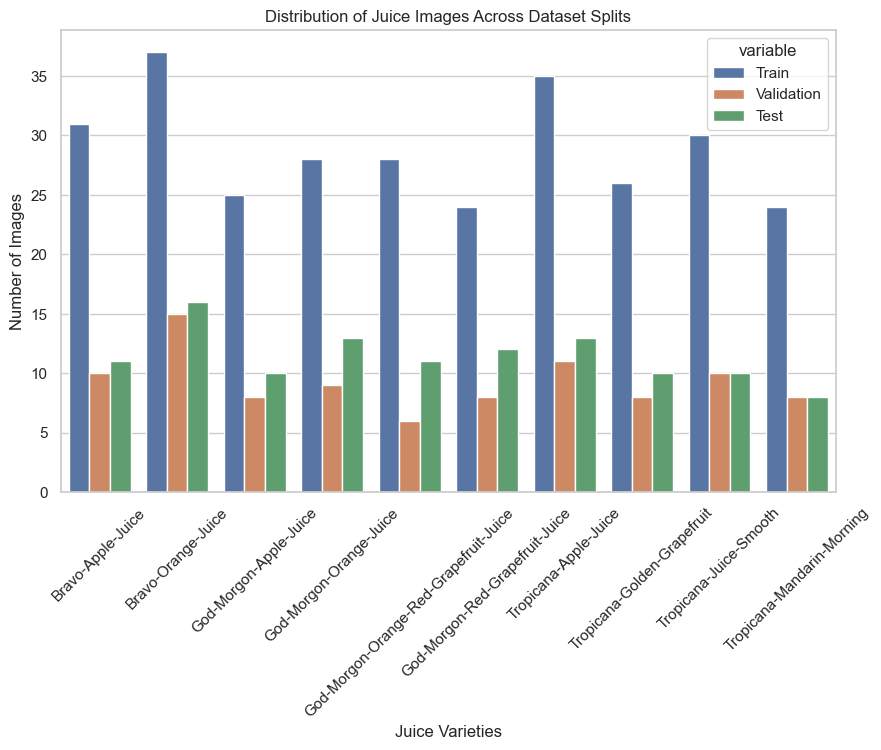

In [80]:
# Filtering for juice-related classes
juice_data = grocery_items_df[grocery_items_df['Category Name (str)'].str.contains("Juice", case=False, na=False)]

# Get unique classes of juices
juice_classes = juice_data['Class Name (str)'].unique()

# Prepare a DataFrame to hold the counts
columns = ['Juice Variety', 'Train', 'Validation', 'Test']
data = []

for juice in juice_classes:
    juice_list = juice_data[juice_data['Class Name (str)'].str.contains(juice, case=False, na=False)]['Class Name (str)'].tolist()

    # Count images for each dataset split
    new_train_count = count_images_by_classes_redistributed(new_train_file, juice_list)
    new_val_count = count_images_by_classes_redistributed(new_val_file, juice_list)
    new_test_count = count_images_by_classes_redistributed(new_test_file, juice_list)

    data.append([juice, new_train_count, new_val_count, new_test_count])

juice_distribution_df = pd.DataFrame(data, columns=columns)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot data
plt.figure(figsize=(10, 6))
juice_plot = sns.barplot(x='Juice Variety', y='value', hue='variable', data=pd.melt(juice_distribution_df, ['Juice Variety']))

# Enhance plot aesthetics
juice_plot.set_title('Distribution of Juice Images Across Dataset Splits')
juice_plot.set_xlabel('Juice Varieties')
juice_plot.set_ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate class labels for better readability

# Show the plot
plt.show()

  Percentage of missing values
  
  The results indicate that there are no missing values in any columns, ensuring the dataset is fully populated and reliable for analysis.
  
  
  Additionally, no duplicate rows were detected, confirming that the dataset is free from redundancy. This clean and well-structured dataset provides a solid foundation for building and training our models.

In [81]:
# Check for missing data in the `grocery_items_df` DataFrame
missing_data_summary = grocery_items_df.isnull().sum()

# Create a summary DataFrame for better readability
missing_data_df = pd.DataFrame({
    "Column": missing_data_summary.index,
    "Missing Count": missing_data_summary.values,
    "Missing Percentage": (missing_data_summary.values / len(grocery_items_df)) * 100
}).sort_values(by="Missing Count", ascending=False)

missing_data_df

Column  Missing Count  Missing Percentage
0                Class Name (str)              0                 0.0
1                  Class ID (int)              0                 0.0
2             Category Name (str)              0                 0.0
3               Category ID (int)              0                 0.0
4         Iconic Image Path (str)              0                 0.0
5  Product Description Path (str)              0                 0.0

In [82]:
# Check for duplicate rows in the dataset
duplicates = grocery_items_df[grocery_items_df.duplicated()]

# Count the number of duplicate rows
num_duplicates = len(duplicates)

# Display duplicates if any
if num_duplicates > 0:
    print(f"Number of duplicate rows: {num_duplicates}")
    display(duplicates.head())  # Display a few duplicate rows
else:
    print("No duplicate rows found in the dataset.")

No duplicate rows found in the dataset.


### 3.4 Identifying the target(s)
The target can be defined at 2 levels - class and category. These are explored below.
1. Class as a target - Class (like "Pink-Lady", "Golden-Delicious", etc.) is the target for the initial goal of recognizing and classifying individual grocery items based on images.

2. Category as a target - After identifying the specific class, we want to group these classes into categories (like "Fruit," "Vegetable," "Juice," etc.). In this case, the category becomes the target.

### 3.5 Visualize Data

Below we take 10 example images and their names.

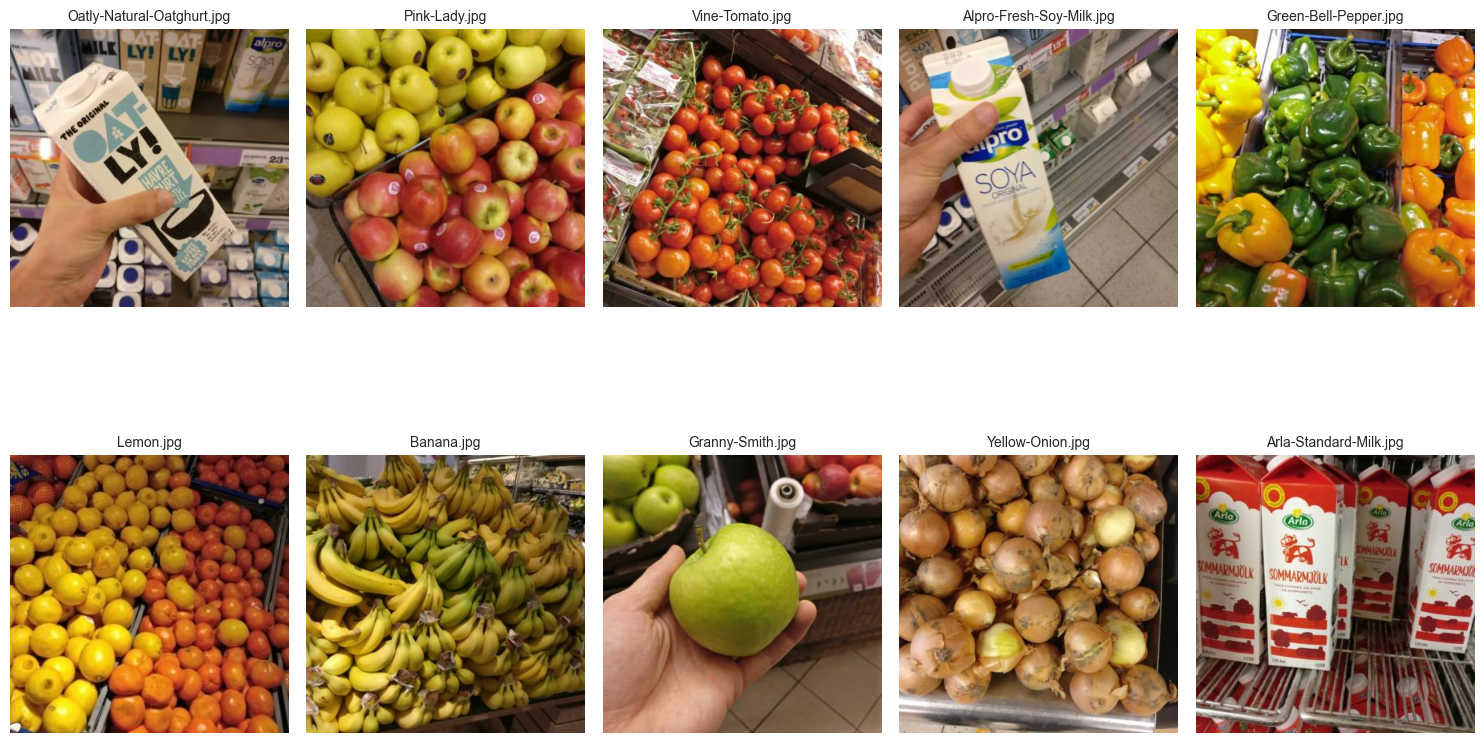

In [83]:
sample_images_path = 'GrocerystoreDataset-master/sample_images/natural'

# Function to display 10 sample images
def display_sample_images(sample_images_path, num_images=10):
    # List all image files in the directory (and subdirectories)
    all_images = []
    for root, dirs, files in os.walk(sample_images_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))
    
    # Randomly select the desired number of images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Plot selected images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # Adjust grid for 10 images
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 sample images
display_sample_images(sample_images_path, num_images=10)


As you can see above are 10 sample natural images from the dataset as an example, with their category and names.

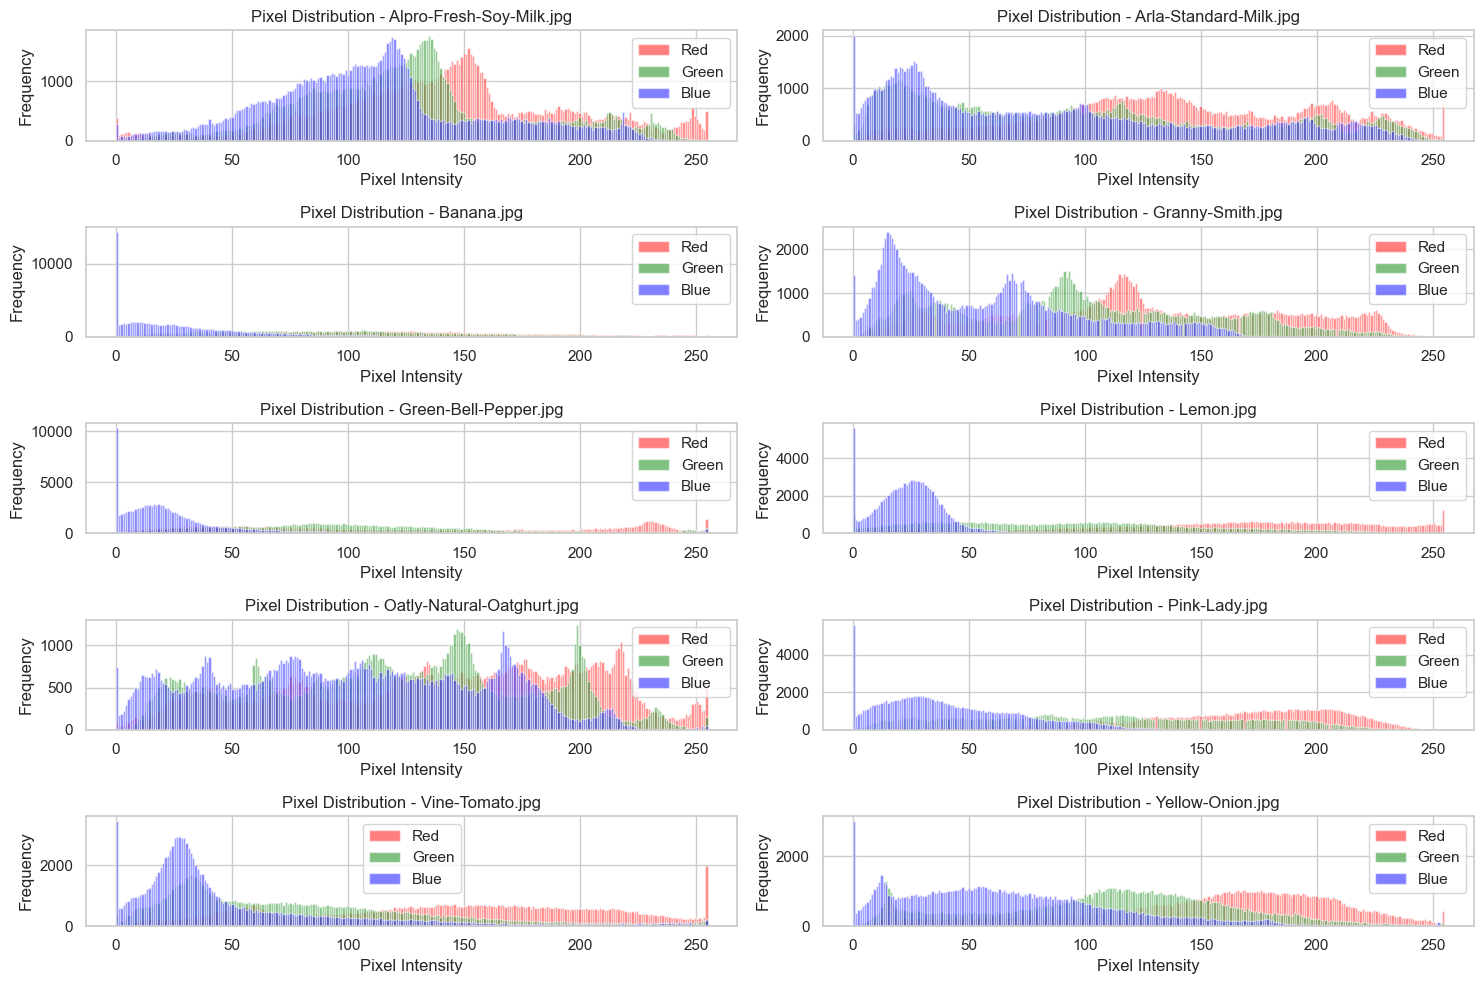

In [84]:
# List image files in the directory
image_files = [os.path.join(sample_images_path, f) for f in os.listdir(sample_images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select 10 images
selected_images = image_files[:10]

# Plot pixel distributions
plt.figure(figsize=(15, 10))

for idx, image_path in enumerate(selected_images):
    # Open and convert the image to RGB format
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)

    # Flatten pixel values for all channels
    red_channel = img_array[:, :, 0].flatten()
    green_channel = img_array[:, :, 1].flatten()
    blue_channel = img_array[:, :, 2].flatten()

    # Plot histograms
    plt.subplot(5, 2, idx + 1)
    plt.hist(red_channel, bins=256, color='red', alpha=0.5, label='Red')
    plt.hist(green_channel, bins=256, color='green', alpha=0.5, label='Green')
    plt.hist(blue_channel, bins=256, color='blue', alpha=0.5, label='Blue')
    plt.title(f'Pixel Distribution - {os.path.basename(image_path)}')  # Show the file name in the title
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

1. Pixel Distribution as a Feature:
The distribution of pixel values in an image reflects important characteristics of the image, such as:

* Brightness: The overall intensity of the image (how light or dark it is).
* Contrast: The variation in pixel intensities (how sharp the features in the image are).
* Texture: The pattern and arrangement of pixel values (e.g., smooth surfaces or rough textures).

For example: Fruits like apples or tomatoes might have a uniform or consistent pixel distribution, while fruits like grapes might have a more varied distribution due to the small details in their texture. By using the histogram of pixel values (or other statistical methods), we can capture these characteristics and turn them into features for classification.

2. RGB Channels as Features:
Images are typically represented in RGB (Red, Green, Blue) channels, where each pixel has three values: one for each color channel. By analyzing the distribution of these values across an image, we can extract even more discriminative features:

* Color Dominance: For example, red apples would have a higher distribution of red values in their RGB channels, whereas green vegetables would have a more dominant green channel.
* Color Histograms: By splitting the image into its R, G, and B components and calculating their individual histograms, you can capture the specific color distribution of the image.

### 3.6 Study Correlations betweeen features

**RGB Color Correlation**

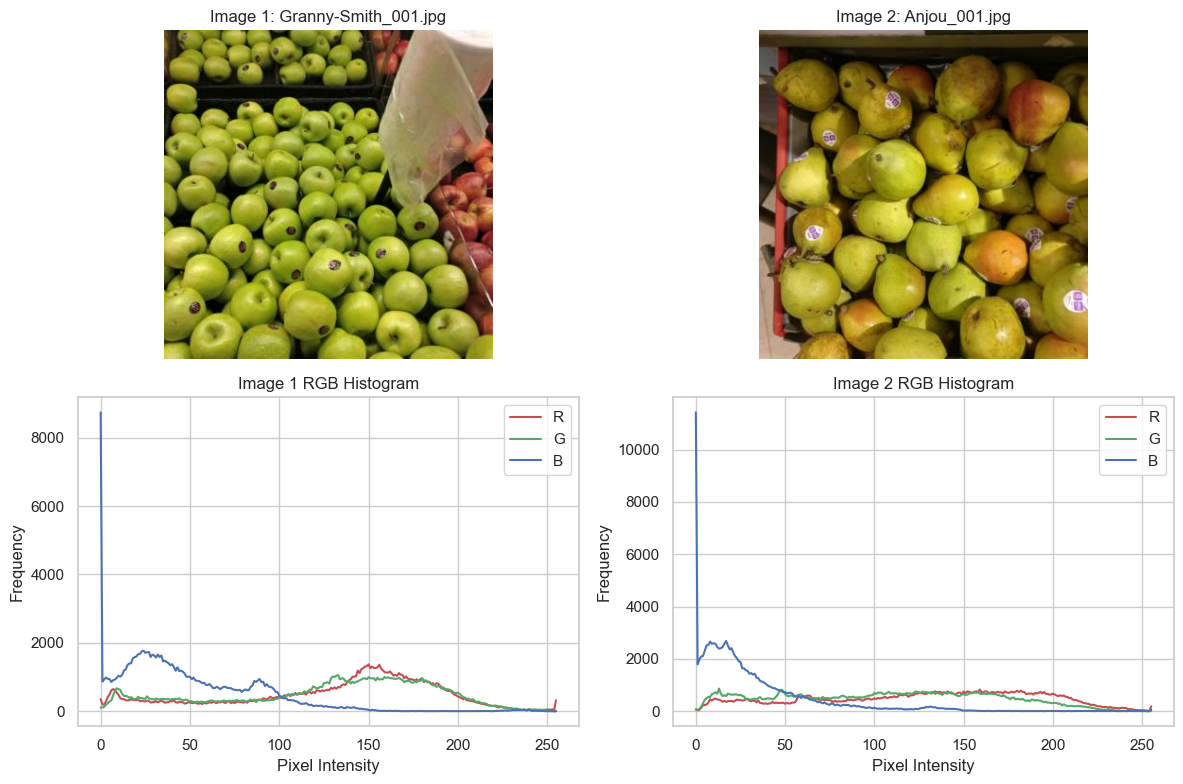

In [85]:
# Function to compute RGB histograms
def compute_rgb_histogram(image_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate histogram for each channel
    color = ('r', 'g', 'b')
    histograms = {}
    for i, col in enumerate(color):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        histograms[col] = hist
    return histograms, image

# Function to visualize images and their histograms
def visualize_images_and_histograms(image1_path, image2_path):
    # Compute histograms and load images
    hist1, img1 = compute_rgb_histogram(image1_path)
    hist2, img2 = compute_rgb_histogram(image2_path)

    # Create a figure for visualization
    plt.figure(figsize=(12, 8))
    
    # Display the first image
    plt.subplot(2, 2, 1)
    plt.imshow(img1)
    plt.title("Image 1: " + os.path.basename(image1_path), fontsize=12)
    plt.axis("off")
    
    # Display RGB histogram for Image 1
    plt.subplot(2, 2, 3)
    for color, hist in hist1.items():
        plt.plot(hist, color=color)  # Use the respective color for the channel
    plt.title("Image 1 RGB Histogram", fontsize=12)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend(['R', 'G', 'B'])
    
    # Display the second image
    plt.subplot(2, 2, 2)
    plt.imshow(img2)
    plt.title("Image 2: " + os.path.basename(image2_path), fontsize=12)
    plt.axis("off")
    
    # Display RGB histogram for Image 2
    plt.subplot(2, 2, 4)
    for color, hist in hist2.items():
        plt.plot(hist, color=color)  # Use the respective color for the channel
    plt.title("Image 2 RGB Histogram", fontsize=12)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend(['R', 'G', 'B'])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Paths to images
image1_path = "GroceryStoreDataset-master\\dataset\\train\\Fruit\\Apple\\Granny-Smith\\Granny-Smith_001.jpg"
image2_path = "GroceryStoreDataset-master\\dataset\\train\\Fruit\\Pear\\Anjou\\Anjou_001.jpg"

# Visualize the images and their histograms
visualize_images_and_histograms(image1_path, image2_path)

**What Does the Code Show?**
- Images and Their Histograms:
The code displays two images side by side.
Below each image, it shows the RGB histogram, which represents the color distribution in that image.

- What the Histograms Represent:
Each channel (Red, Green, Blue) in the histogram shows how much of that color is present at different intensities (from dark to bright).
Peaks in the histogram tell us which colors dominate the image:
For example, a red apple will have a high peak in the red channel.

- Overlap in Histograms:
Granny Smith apples and pears both have a strong green channel because they share a similar color profile.
Their RGB histograms might look similar, especially in the green channel, but there could still be subtle differences:
Apples might have a slightly higher contribution from the red channel due to color gradients or lighting.
Pears might have a smoother distribution in the green channel due to their surface texture.

**Challenge for Classification:**
Since the color features in these two images overlap, color alone may not be enough to classify these items accurately.

**Edge Detection**

Lets explore another way to differentiate between these images

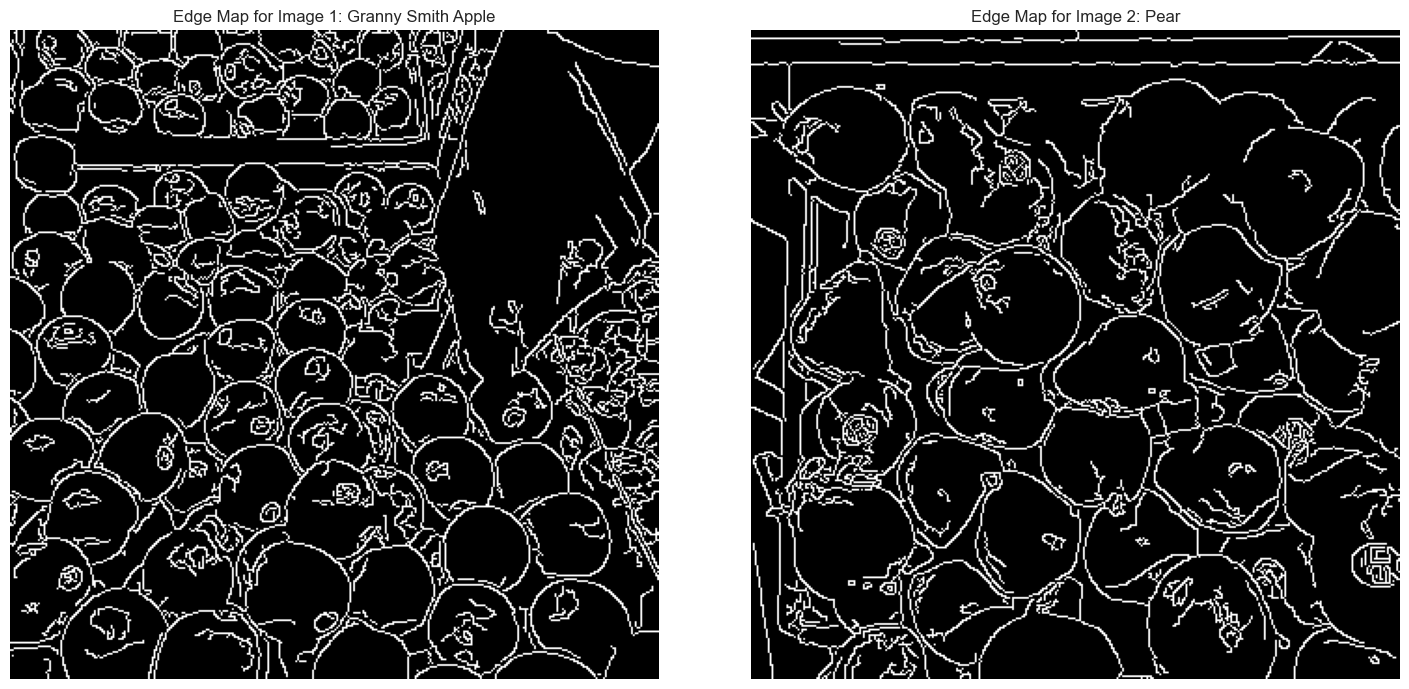

In [86]:
# Function to compute edge map using Canny Edge Detection
def compute_edge_map(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale for edge detection
    edges = cv2.Canny(image, threshold1=50, threshold2=150)  # Canny edge detection
    return edges

# Function to display edge maps for two images
def display_edge_maps(image1_path, image2_path):
    # Compute edge maps
    edges1 = compute_edge_map(image1_path)
    edges2 = compute_edge_map(image2_path)
    
    # Plot edge maps
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    axes[0].imshow(edges1, cmap="gray")
    axes[0].set_title("Edge Map for Image 1: Granny Smith Apple")
    axes[0].axis("off")
    
    axes[1].imshow(edges2, cmap="gray")
    axes[1].set_title("Edge Map for Image 2: Pear")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Display edge maps
display_edge_maps(image1_path, image2_path)

**What This Does:**
- Canny Edge Detection: This function converts the image to grayscale and then applies the Canny edge detection algorithm, which highlights the boundaries and shapes in the image.

- Display Edge Maps: This code compares the edge maps of two images (Granny Smith apple and Anjou pear), showing how the shapes and boundaries differ between the images.

**Why use this?:**

- Color alone may not be sufficient for differentiating between objects like apples and pears, especially when the colors are similar (e.g., both having a lot of green).

- Edge detection focuses on shapes, boundaries, and contours in the image. It allows us to capture the structural features of the objects, like the roundness of an apple or the texture of a pear's skin.

Example: Even if the colors are similar (both have green tones), their shapes will differ:
- Apples are typically rounder, while pears often have a more tapered or elongated shape.
- Edge detection highlights these structural differences and can help the model distinguish between objects that might be hard to tell apart based on color alone.

**Feature Correlations Summary**

- Edge detection enhances the ability to detect structural differences between images, making it easier for the model to differentiate objects based on shape and texture, rather than just color.

- It’s especially helpful when objects have similar colors or are affected by external factors like lighting, which may change their appearance but not their structure.

- Combining color information (like histograms) with edge information allows the model to capture a broader spectrum of features, improving its ability to classify and differentiate similar objects.

### 3.7 Data transformations
**Transformations Less Relevant for Image Data**
- Logarithmic, Square Root, and Box-Cox Transformations
- Statistical Normalization (= Standard Scaling)
Reason: For image data, transformations like standard scaling (mean of 0 and std of 1) or logarithmic transformations used to achieve symmetrical distributions can be problematic because they can disrupt the inherent relationships and visual patterns in the image data that are critical for accurate image processing and recognition.

Here are a few ways applying these transformations might negatively affect image data processing:
* Loss of Relative Intensity Information:

    Example: Consider an image classification task to distinguish between daytime and nighttime scenes. Daytime images typically have higher average pixel intensities (brightness) compared to nighttime images. Standard scaling could normalize these differences, making it difficult for a model to use overall brightness as a distinguishing feature.

* Alteration of Color Relationships:

    Example: In tasks where color is a critical identifier, such as classifying traffic lights or flowers, the relative intensities and distributions of the RGB channels convey important information. Standard scaling each channel independently to have zero mean and unit variance could misalign these relationships, potentially leading to misclassifications or loss of discriminative power.

* Distortion of Image Content:

    Example: Applying a logarithmic transformation to normalize pixel value distributions can disproportionately enhance the visibility of darker areas while compressing the scale of brighter areas. This could be detrimental in medical imaging (e.g., X-rays or MRI scans), where the precise range of pixel intensities is crucial for identifying subtle anomalies.


**Relevance (or more like non-relevance) of Standard Scaling in Image Classification**

- Non-reliance on Distance Metrics:

    Most advanced image classification tasks today rely on Convolutional Neural Networks (CNNs) or similar deep learning models. These models do not explicitly calculate distances between input data points in their raw form, as methods like k-Nearest Neighbors (k-NN) or k-Means clustering do. Instead, CNNs apply filters to extract features and use non-linear activation functions to capture complex patterns in the data.
    In such models, the emphasis is less on the scale of individual pixel values regarding their distance to one another and more on how these values represent features like edges, textures, or color gradients. - Which is explored in the section 3.6

- Feature Normalization in CNNs:

    While standard scaling (zero mean and unit variance) per feature across the dataset is common in structured data, image data often benefits from simpler forms of scaling. A typical practice in image processing for CNNs is simply scaling pixel values to a [0, 1] range by dividing by 255 (the maximum pixel value for standard 8-bit images).
    This form of scaling helps to standardize the input data and aids in stabilizing the training process by keeping the numerical values small and manageable, which is particularly important for the gradient descent optimization algorithm used in training deep networks.

**Conclusion:** We will apply pixel value scaling to the [0, 1] range as our primary transformation method. This technique seems promising in ensuring faster and more stable convergence* of neural networks. Scaling pixel values to a normalize range of 0 and 1 prevents uneven weight updates during training, which can otherwise lead to inefficiencies and slow convergence rates.

*Convergence = The process by which the algorithm iteratively adjusts the model parameters (typically the weights) to minimize or reduce the loss function to its lowest possible value. Convergence is an indication that the model is effectively learning the underlying pattern in the data and is reaching a point where further training will not significantly improve its performance.





## 4. Prepare the data

Work on copies of the data (keep the original dataset intact).

In [87]:
# Define original and working dataset paths
original_dataset_path = 'GroceryStoreDataset-master/'
working_dataset_path = 'GroceryStoreDataset-working/'

# Function to copy the dataset
def copy_dataset(original_path, working_path):
    if not os.path.exists(working_path):
        shutil.copytree(original_path, working_path)
        print(f"Dataset copied successfully to: {working_path}")
    else:
        print(f"Working dataset already exists at: {working_path}")

copy_dataset(original_dataset_path, working_dataset_path)

# Verify the contents of the copied dataset
copied_contents = os.listdir(working_dataset_path)
print("Copied dataset contents:", copied_contents)

Working dataset already exists at: GroceryStoreDataset-working/
Copied dataset contents: ['dataset', 'LICENSE', 'README.md', 'sample_images']


#### 4.1 Data cleaning
We will look at the outliers in respect to the image size.

In [88]:
# Let's create a DataFrame that will hold the image file paths, names, sizes, and dimensions
# Function to read image paths from a text file
def read_image_paths(file_path):
    with open(file_path, 'r') as f:
        return [line.strip().split(',')[0] for line in f if line.strip()]
# Gather all image paths from the train, validation, and test datasets
image_paths = []
image_paths.extend(read_image_paths(train_file))
image_paths.extend(read_image_paths(val_file))
image_paths.extend(read_image_paths(test_file))

# Collect file sizes and names
file_sizes = []
file_paths = []
file_names = []
dimensions = []
base_path = 'GroceryStoreDataset-master/dataset/'
for file_path in image_paths:
    full_path = os.path.join(base_path, file_path)
    if file_path.endswith(('.png', '.jpg', '.jpeg')):
        try: 
            size_kb = os.path.getsize(full_path) / 1024  # Convert to Kilobytes
            file_sizes.append(size_kb)
            file_paths.append(full_path)
            file_names.append(os.path.basename(file_path))

            # Open image and get dimensions
            with Image.open(full_path) as img:
                dimensions.append(f"{img.width}x{img.height}")
        except FileNotFoundError:
            print(f"File not found: {full_path}")
            continue

# Create a dataframe to hold the image info
file_sizes_df = pd.DataFrame({
    'File Path': file_paths,
    'File Name': file_names,
    'File Size (KB)': file_sizes,
    'Dimensions': dimensions    # Dimensions will be used later on
})
file_sizes_df.head()

File Path  \
0  GroceryStoreDataset-master/dataset/train/Fruit...   
1  GroceryStoreDataset-master/dataset/train/Fruit...   
2  GroceryStoreDataset-master/dataset/train/Fruit...   
3  GroceryStoreDataset-master/dataset/train/Fruit...   
4  GroceryStoreDataset-master/dataset/train/Fruit...   

                  File Name  File Size (KB) Dimensions  
0  Golden-Delicious_001.jpg       15.125000    348x348  
1  Golden-Delicious_002.jpg       19.124023    348x348  
2  Golden-Delicious_003.jpg       15.535156    348x348  
3  Golden-Delicious_004.jpg       18.869141    348x348  
4  Golden-Delicious_005.jpg       17.133789    348x348

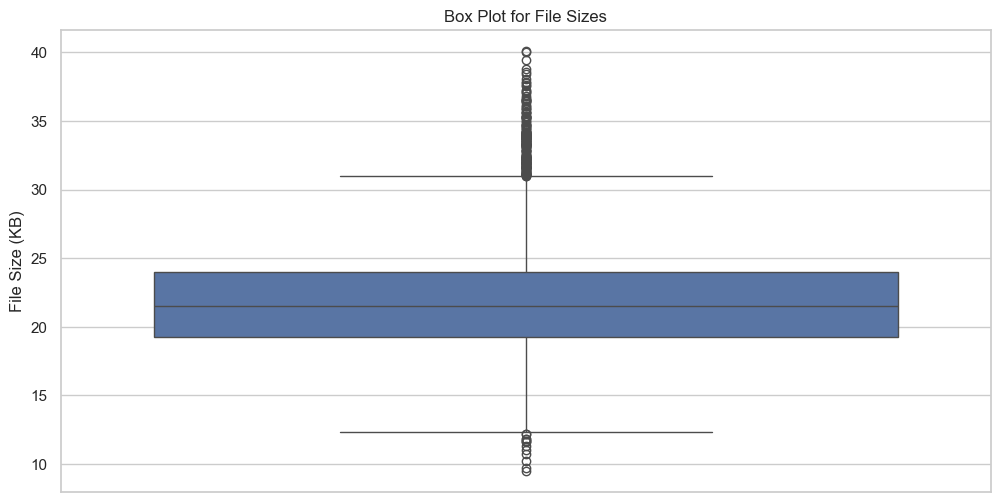

In [89]:
# Display the box plot for file sizes to see the outliers
plt.figure(figsize=(12, 6))
sns.boxplot(y=file_sizes_df['File Size (KB)'])
plt.title('Box Plot for File Sizes')
plt.ylabel('File Size (KB)')
plt.show()


In [90]:
# Calculate Q1, Q3, and IQR
Q1 = file_sizes_df['File Size (KB)'].quantile(0.25)
Q3 = file_sizes_df['File Size (KB)'].quantile(0.75)
IQR = Q3 - Q1

# Calculate upper bounds for outliers using the typical 1.5 * IQR beyond the quartiles
upper_bound = Q3 + 1.5 * IQR

# Filter the images for any entries beyond the bounds, effectively identifying the outliers
outliers = file_sizes_df[(file_sizes_df['File Size (KB)'] > upper_bound)]

# Print outliers
print("Outlier files (based on box plot criteria):")
display(outliers.head())
display(outliers.shape)

Outlier files (based on box plot criteria):


File Path             File Name  \
53   GroceryStoreDataset-master/dataset/train/Fruit...  Granny-Smith_009.jpg   
75   GroceryStoreDataset-master/dataset/train/Fruit...  Granny-Smith_031.jpg   
86   GroceryStoreDataset-master/dataset/train/Fruit...  Granny-Smith_042.jpg   
95   GroceryStoreDataset-master/dataset/train/Fruit...  Granny-Smith_051.jpg   
280  GroceryStoreDataset-master/dataset/train/Fruit...       Avocado_003.jpg   

     File Size (KB) Dimensions  
53        33.313477    348x464  
75        33.094727    348x464  
86        31.888672    348x464  
95        32.851562    348x464  
280       33.666992    348x464

(184, 4)

184 images were identified as the upper bound outliers. We disregarded the lower bound ones as the issue is caused by images with large size. 
The file size of these outliers is 31-40 kB in comparison to the images in the interquantile range where the image size is between 19 and 24 kB.

Next, we will take a look at the upper bound outliers. We'll display 15 images.

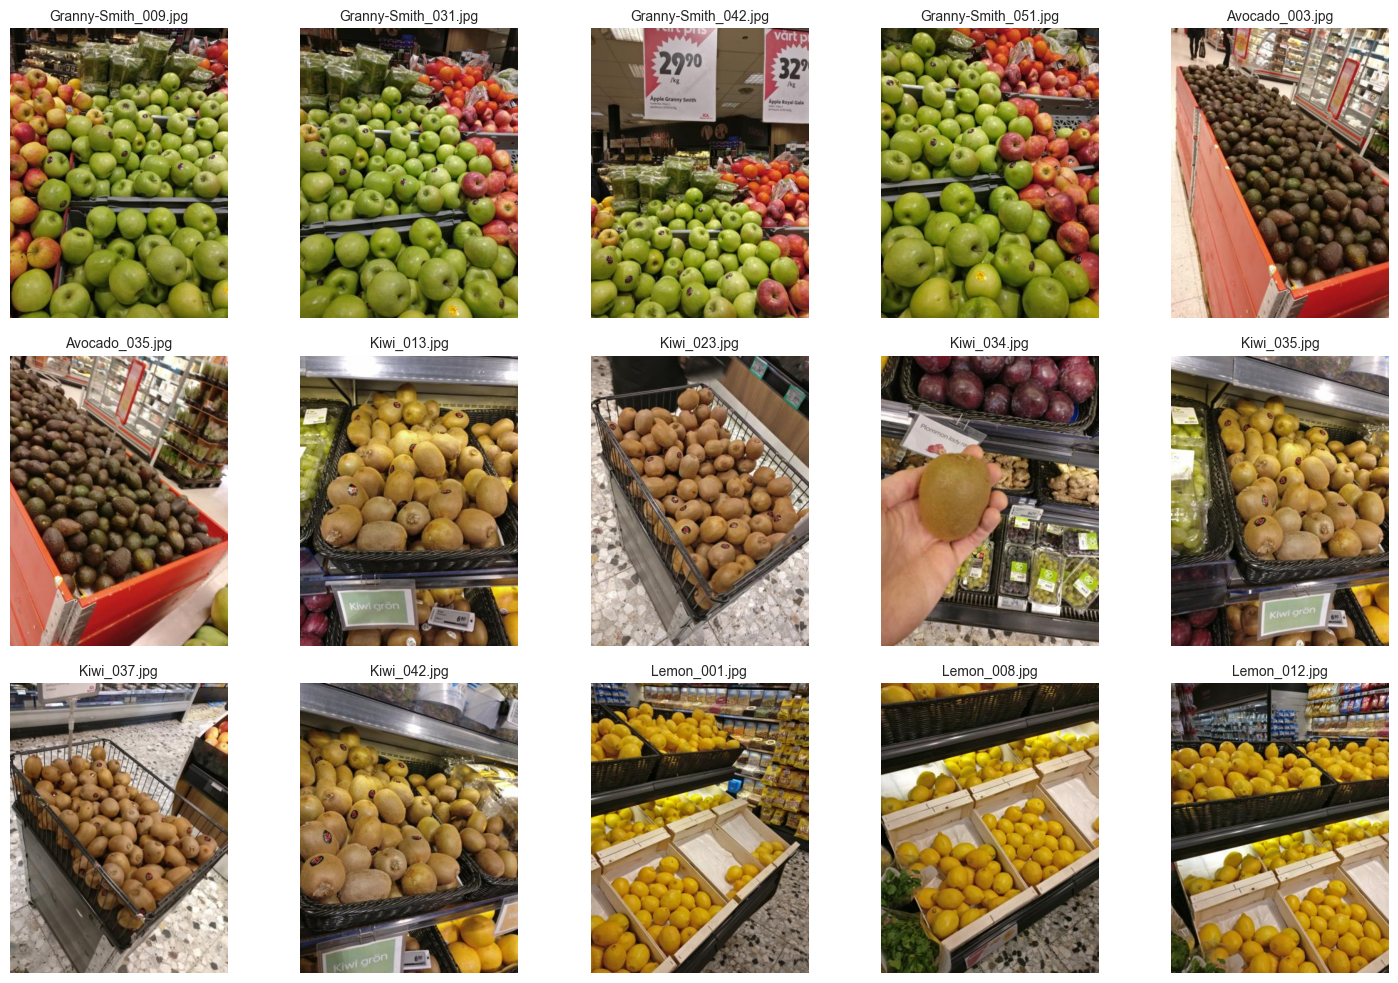

In [91]:
# Plot selected images
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(outliers['File Path'][:15]):
    img = Image.open(img_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

After careful consideration, we have decided not to take any action on these outliers. The detected outliers do not necessarily represent incorrect or invalid data. As it turns out from the analysis above, larger file sizes still provide valuable information for training the model. Removing or altering these outliers could risk discarding valid and potentially meaningful examples, which could inadvertently reduce the model's ability to generalize.
What is more relevant to our objective is the process of cropping and resizing images to the desired size and aspect ratio. This step might also influence the file sizes, rendering the above-mentioned consideration of outliers as less critical. We will further explore the techniques of cropping and resizing in Section 4.3 on Feature Engineering.

#### 4.2 Feature Selection

Negative effect of removing features from the images:

- Essential Features: Color, shape, and other visual characteristics are crucial for differentiating between products. Removing these features could negatively impact the model's ability to accurately classify items.

- Risk of Increased Errors: Removing certain features increases the likelihood of errors in classification. Every feature contributes to the model's understanding of the image.

- Background Noise: While background noise may seem unnecessary, which can help the model recognize products in various environments. Removing background elements could reduce the model’s robustness, making it less adaptable to real-world settings, where noise is common. In certain situations where the background is overwhelmingly noisy or fills too much space, then it would be necessary to remove the background.

In Conclusion, Although there is potential for too much background noises in the images we currently have in our dataset. We will be moving forward without making and changes to the background or other features in the images.

#### 4.3 Feature engineering
Elaboration of the suggested steps:

##### 4.3.1 Discretizing Continuous Features

Discretization is more common in tabular datasets with numerical features (e.g., income levels or ages). In our case, the dataset primarily consists of image data and categorical metadata, making this technique less relevant.

##### 4.3.2 Using One-Hot Encoding

One-hot encoding could be relevant when handling categorical metadata, such as "Class Name" or "Category Name." For example, if we include metadata alongside image features (e.g., combining "Juice" with its corresponding image), one-hot encoding ensures the model can interpret these categories numerically. We can use it for converting categorical variables (class names such as "Granny Smith") into binary vectors for classification tasks.

##### 4.3.3 Aggregating Features into Promising New Features

For image features extracted using CNNs, aggregation is usually unnecessary since the CNN itself learns hierarchical feature representations. We could potentially use it in a more advanced model where we integrate metadata (e.g., class and category names), and aggregate features hierarchically:

Combining "Granny Smith" and "Golden Delicious" under "Apple."
Aggregating fruit categories ("Apple", "Banana", etc.) into a broader "Fruit" group.



##### 4.3.4 Dimension reduction
The following section focuses on the cropping and resizing the images to the desired size and aspect ratio.
Let's double-check the image dimensions to see if they are the same.

In [92]:
unique_dimensions = file_sizes_df['Dimensions'].nunique()

# Print the number of unique dimensions
print(f"Number of unique dimensions: {unique_dimensions}")

# Print out what these dimensions are and how many images there are for each dimension
dimension_counts = file_sizes_df['Dimensions'].value_counts()
print("Count of images per dimension:")
print(dimension_counts)

Number of unique dimensions: 3
Count of images per dimension:
Dimensions
348x348    4958
348x464     426
464x348      37
Name: count, dtype: int64


The image dimensions are not aligned. This observation is not ideal as it is crucial for CNN architectures to receive input images of the same dimensions. This means we have to crop and resize the images to the desired size and aspect ratio. 

Let's resize all the picture to dimensions 348x348 pixels.

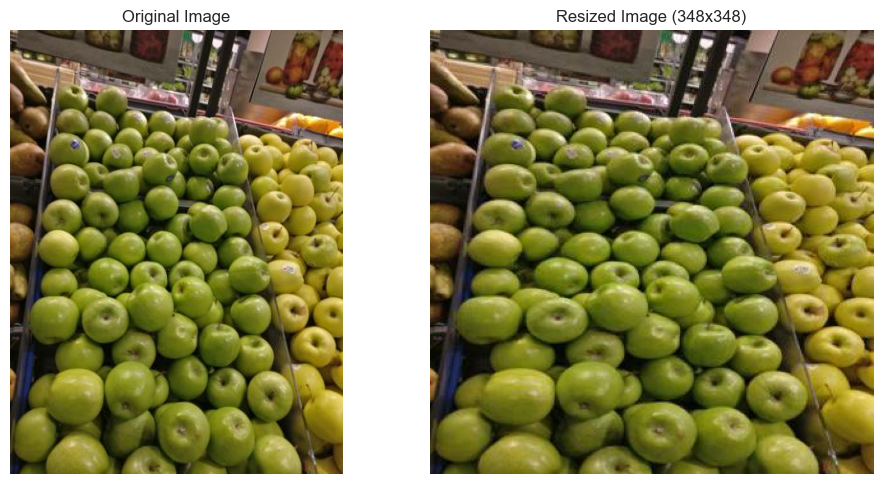

In [94]:
dataset_dir = 'GroceryStoreDataset-master/dataset'
os.listdir(dataset_dir)
resized_dir = 'GroceryStoreDataset-working/dataset'

# Paths to original and resized images
original_image_path = os.path.join(dataset_dir, 'test', 'Fruit', 'Apple', 'Granny-Smith', 'Granny-Smith_031.jpg')
resized_image_path = os.path.join(resized_dir, 'test', 'Fruit', 'Apple', 'Granny-Smith', 'Granny-Smith_031.jpg')

# Open the original and resized images
original_image = Image.open(original_image_path)
resized_image = Image.open(resized_image_path)

# Display side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(resized_image)
axes[1].set_title("Resized Image (348x348)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


Above is an original image (dimensions 348x464) and the resized image with dimensions (348x464).

#### 4.4 Feature scaling - pixel transformation
We focus on it in feature prep in the models.

## 5. Training models

Steps for Each Member

* Data Preparation:

-Resize images (already done).

-Normalize pixel values to the range [0, 1].

* Model Training:

-Train the assigned model type using your training data.

-Use the validation set for hyperparameter tuning.

* Performance Evaluation:

-Measure accuracy, precision, recall, F1-score.

-Generate confusion matrices and analyze errors.

* Error Analysis:

-Look at misclassified images or feature importance.

-Discuss patterns and possible improvements (e.g., augmentations, additional features).

### 5.1 CNN

#### 5.1.1 Introduction

Convolutional Neural Networks (CNNs) are a specialized type of neural network designed for processing structured grid data, such as images. They have become the go-to approach for image classification tasks due to their ability to automatically learn spatial hierarchies of features from raw input data. Unlike traditional machine learning approaches, which require handcrafted features, CNNs extract relevant patterns, edges, and textures through a series of convolutional and pooling operations.

How CNNs Work
CNNs operate in a hierarchical manner where data is processed in stages:

Convolutional Layers:
These layers apply filters (kernels) to the input image to detect low-level features such as edges, corners, and textures. As the network deepens, it learns higher-level abstractions like shapes or objects.

Pooling Layers:
Pooling reduces the spatial dimensions of the feature maps, making the network more efficient and less prone to overfitting. Max pooling is commonly used to retain the most significant features.

Fully Connected Layers:
After extracting features, the flattened output is passed to dense layers to make predictions. The final layer uses an activation function (e.g., softmax) to output class probabilities.

Regularization Techniques:
Techniques such as Dropout and L2 regularization are often added to prevent overfitting, ensuring better generalization on unseen data.

Why CNNs for Image Classification?
CNNs excel at image classification because of their unique ability to preserve the spatial structure of images while learning complex patterns. Unlike fully connected networks, CNNs reduce the number of parameters through weight sharing, making them computationally efficient and better suited for large datasets. Their hierarchical feature extraction process allows them to recognize intricate details in images, enabling high accuracy in tasks like object detection, image recognition, and classification.


In [4]:
def parse_data_file(file_path, base_dir):
    image_paths = []
    labels = []

    # Define category based on the folder structure
    def get_category_from_folder(image_path):
        # Check the folder path to determine if it's a fruit, vegetable, or package
        if 'Fruit' in image_path:
            return 'fruit'
        elif 'Vegetable' in image_path:
            return 'vegetable'
        elif 'Package' in image_path:
            return 'package'
        else:
            return 'unknown'  # In case there are any unexpected categories

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Split the line based on the format: <image_path>,<label>,<other>
            parts = line.split(',')
            if len(parts) != 3:  # Ensure there are exactly 3 parts
                print(f"Skipping invalid line: {line}")
                continue

            image_path, label_num, _ = parts
            image_path = image_path.strip()  # Strip spaces around the image path
            label_num = int(label_num.strip())  # Convert label to an integer

            # Get the category based on the folder structure
            label = get_category_from_folder(image_path)

            # If the category is recognized, add the image path and label
            if label != 'unknown':
                image_paths.append(os.path.join(base_dir, image_path))
                labels.append(label)
            else:
                print(f"Warning: Could not determine label for image '{image_path}'")

    # Create DataFrame with image paths and labels
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    return df


def preprocessing_pipeline_from_dataframe(train_df, val_df, image_size=(348, 348), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values

    # Create the train generator (only using the three categories)
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    # Create the validation generator (only using the three categories)
    val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',
        y_col='label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Usually we don't shuffle validation data
    )

    return train_generator, val_generator

def cnn_pipeline_with_resnet(train_generator, val_generator, epochs=5):
    # Load the pretrained ResNet50 model without the top classification layer
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(348, 348, 3))
    base_model.trainable = False  # Freeze the base model during initial training

    # Get the number of classes from the train generator
    num_classes = len(train_generator.class_indices)  # This will give you the number of classes

    # Build the model
    resnetmodel = Sequential([
        base_model,                                  # Pretrained ResNet50 as the feature extractor
        GlobalAveragePooling2D(),                   # Pooling layer to reduce dimensions
        Dense(128, activation='relu'),              # Fully connected layer
        Dropout(0.5),                               # Dropout for regularization
        Dense(num_classes, activation='softmax')    # Output layer for multi-class classification
    ])

    # Compile the model
    resnetmodel.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',      # Monitor the validation loss
        patience=5,              # Stop if no improvement after 5 epochs
        restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
    )

    # Train the model
    history = resnetmodel.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]  # Add EarlyStopping to callbacks
    )

    # Evaluate the model on validation data
    val_loss, val_accuracy = resnetmodel.evaluate(val_generator)
    print(f"Final Validation Loss: {val_loss:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Get the predictions on the validation set
    val_predictions = resnetmodel.predict(val_generator, verbose=1)
    val_predictions = np.argmax(val_predictions, axis=1)  # Convert to class indices (argmax)

    # Get the true labels (ground truth) from the validation set
    true_labels = val_generator.classes  # These are the true class labels for the validation set

    # Generate the classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, val_predictions, target_names=val_generator.class_indices.keys()))

    # Return the model, base_model, history from the initial training
    return resnetmodel, base_model, history


#### 5.1.2 Run and Compare Performance

In [5]:
# Paths to text files and base directory
train_txt_path = "GroceryStoreDataset-working/dataset/train.txt"
val_txt_path = "GroceryStoreDataset-working/dataset/val.txt"
base_dir = "GroceryStoreDataset-working/dataset"

# Step 1: Parse text files to DataFrames
train_data = parse_data_file(train_txt_path, base_dir)
val_data = parse_data_file(val_txt_path, base_dir)

# Check the first few rows of the DataFrame
print(train_data.head())

# Step 2: Preprocess data using the new DataFrames
train_gen, val_gen = preprocessing_pipeline_from_dataframe(train_data, val_data, image_size=(348, 348))

# Step 3: Train the model
resnetmodel, base_model, history = cnn_pipeline_with_resnet(train_gen, val_gen, epochs=5)

                                          image_path  label
0  GroceryStoreDataset-working/dataset\test/Fruit...  fruit
1  GroceryStoreDataset-working/dataset\train/Frui...  fruit
2  GroceryStoreDataset-working/dataset\val/Fruit/...  fruit
3  GroceryStoreDataset-working/dataset\train/Frui...  fruit
4  GroceryStoreDataset-working/dataset\test/Fruit...  fruit
Found 3220 validated image filenames belonging to 3 classes.
Found 1055 validated image filenames belonging to 3 classes.


C:\Users\popca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - accuracy: 0.3756 - loss: 1.3821 - val_accuracy: 0.4408 - val_loss: 1.0659
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.4483 - loss: 1.0702 - val_accuracy: 0.4408 - val_loss: 1.0646
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 410s 4s/step - accuracy: 0.4277 - loss: 1.0799 - val_accuracy: 0.4408 - val_loss: 1.0592
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.4489 - loss: 1.0628 - val_accuracy: 0.4408 - val_loss: 1.0502
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 387s 4s/step - accuracy: 0.4562 - loss: 1.0465 - val_accuracy: 0.4408 - val_loss: 1.0426
33/33 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7659 - loss: 0.9077
Final Validation Loss: 1.0426
Final Validation Accuracy: 44.08%
33/33 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step

Classification Report:
              precision    recall  f1-score   support

       fruit       0.44      1.00      0.61       465
     package       0.00      0.00      0.00       3

C:\Users\popca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\popca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\popca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

#### 5.1.3 Feature importance 

In [ ]:
# Load your trained model
model = resnetmodel  # Replace with the trained model you already have

# Function to preprocess the image
def preprocess_image(image_path, target_size=(348, 348)):
    img = load_img(image_path, target_size=target_size)  # Load image
    img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

image_path = 'GroceryStoreDataset-working/dataset/test/Fruit/Apple/Pink-Lady/Pink-Lady_001.jpg'
img, img_array = preprocess_image(image_path)

def generate_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    # Step 1: Create a model that maps the input image to activations of the last conv layer
    # and the model's predictions.
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Step 2: Compute the gradient of the predicted class score with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = np.argmax(predictions[0])  # Use top class prediction if not specified
        loss = predictions[:, pred_index]  # Target class score
    
    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Step 3: Calculate the mean intensity of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    # Step 4: Weight the activations of the last conv layer by the pooled gradients
    conv_outputs = conv_outputs[0]
    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    
    # Step 5: Compute the heatmap by averaging over all channels
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]
    
    return heatmap.numpy()


In [ ]:
def display_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap to match the input image size
    heatmap = tf.image.resize(heatmap, (img.size[1], img.size[0]))
    heatmap = np.uint8(255 * heatmap)  # Scale to 0-255 range
    heatmap = plt.cm.jet(heatmap)[:, :, :3]  # Apply colormap (e.g., jet)
    
    # Superimpose the heatmap on the original image
    superimposed_img = np.array(img) * 0.5 + heatmap * 0.5
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    
    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()

# Generate Grad-CAM heatmap
last_conv_layer_name = 'conv5_block3_out'  # Replace with your last conv layer's name
heatmap = generate_gradcam(model, img_array, last_conv_layer_name)

# Display the heatmap
display_gradcam(img, heatmap)

#### 5.1.4 Analyse types of errors made

In [ ]:
# Generate predictions on the validation set
val_predictions = model.predict(val_generator, verbose=1)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert probabilities to class indices

# Get the true labels (ground truth) from the validation set
true_labels = val_generator.classes

# Get the class labels
class_labels = list(val_generator.class_indices.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, val_predictions)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

The latest CNN model was trained and evaluated on a dataset of 2,640 training images and 296 validation images, spanning 3 classes: Fruit, Packages, and Vegetables. The final model performance indicates significant challenges in classification accuracy, particularly in recognizing certain classes.

Key Results
Final Validation Accuracy: 58.45%
Final Validation Loss: 0.9627
Test Accuracy: 56.38%
Precision and Recall Analysis:
Fruit: Precision = 0.36, Recall = 0.65
Packages: Precision = 0.32, Recall = 0.30
Vegetables: Precision = 0.00, Recall = 0.00

Error Analysis
Class Imbalance:

The model heavily favors the Fruit class, with a recall of 0.65, meaning it correctly identifies 65% of Fruit samples but performs poorly on the Packages and Vegetables classes.
For the Vegetables class, the model predicted no samples, resulting in a precision, recall, and f1-score of 0.00. This suggests the model fails to learn distinctive features for this class.
Overfitting or Underfitting:

The model's training accuracy plateaued at around 46-47%, while the validation accuracy fluctuated between 56-58%, suggesting the model struggles to generalize to unseen data.
Despite reducing the validation loss, the accuracy improvements were limited, indicating the model may not be learning complex features effectively.
Poor Feature Discrimination:

The Packages and Vegetables classes likely share similar features (e.g., shapes, edges, and textures), making it difficult for the model to differentiate between them.
Undefined Metrics for Vegetables:

The sklearn warning highlights that precision and recall for the Vegetables class are undefined because the model did not predict any instances for this class. This emphasizes a significant failure in classifying this category.

#### 5.1.6 CNN - Non Pretrained Model
 This model instead will not be pretrained, as the previous pretrained models performance had many significant errors that could not be addressed without further significant changes. Instead we will use our own CNN Model to access and compare to the previous and see if this is a symptom of the model, dataset, or a combination of both

In [22]:
# Step 1: Function to parse a single text file
def parse_data_file(file_path, base_dir):
    image_paths = []
    labels = []

    # Define category based on the folder structure
    def get_category_from_folder(image_path):
        # Check the folder path to determine if it's a fruit, vegetable, or package
        if 'Fruit' in image_path:
            return 'fruit'
        elif 'Vegetable' in image_path:
            return 'vegetable'
        elif 'Package' in image_path:
            return 'package'
        else:
            return 'unknown'  # In case there are any unexpected categories

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Split the line based on the format: <image_path>,<label>,<other>
            parts = line.split(',')
            if len(parts) != 3:  # Ensure there are exactly 3 parts
                print(f"Skipping invalid line: {line}")
                continue

            image_path, label_num, _ = parts
            image_path = image_path.strip()  # Strip spaces around the image path
            label_num = int(label_num.strip())  # Convert label to an integer

            # Get the category based on the folder structure
            label = get_category_from_folder(image_path)

            # If the category is recognized, add the image path and label
            if label != 'unknown':
                image_paths.append(os.path.join(base_dir, image_path))
                labels.append(label)
            else:
                print(f"Warning: Could not determine label for image '{image_path}'")

    # Create DataFrame with image paths and labels
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    return df


# Step 2: Preprocessing pipeline from DataFrame
def preprocessing_pipeline_from_dataframe(train_df, val_df, image_size=(348, 348), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize pixel values

    # Training generator
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    # Validation generator
    val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',
        y_col='label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator


def cnn_pipeline_basic_with_l2(train_generator, val_generator, epochs=10):
    # Get the number of classes from the train generator
    num_classes = len(train_generator.class_indices)

    # Build the model
    model = Sequential([
        # Convolutional block 1
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(348, 348, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        # Convolutional block 2
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # Convolutional block 3
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Fully connected layers
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Use the number of classes here
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Set up EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"Final Validation Loss: {val_loss:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Get the predictions on the validation set
    val_predictions = resnetmodel.predict(val_generator, verbose=1)
    val_predictions = np.argmax(val_predictions, axis=1)  # Convert to class indices (argmax)

    # Get the true labels (ground truth) from the validation set
    true_labels = val_generator.classes  # These are the true class labels for the validation set

    # Generate the classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, val_predictions, target_names=val_generator.class_indices.keys()))

    # Return the model and training history
    return model, history


In [23]:
# Step 4: Integrating Everything
# Paths to train and validation text files
# Paths to text files and base directory
train_txt = "GroceryStoreDataset-working/dataset/train.txt"
val_txt = "GroceryStoreDataset-working/dataset/val.txt"
base_dir = "GroceryStoreDataset-working/dataset"

# Parse the train and validation text files
train_df = parse_data_file(train_txt, base_dir)
val_df = parse_data_file(val_txt, base_dir)

# Preprocess the data
train_gen, val_gen = preprocessing_pipeline_from_dataframe(train_df, val_df, image_size=(348, 348))

# Train the CNN model
model, history = cnn_pipeline_basic_with_l2(train_gen, val_gen, epochs=3)

Found 3220 validated image filenames belonging to 3 classes.
Found 1055 validated image filenames belonging to 3 classes.


C:\Users\popca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\popca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
101/101 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.4826 - loss: 6.6803 - val_accuracy: 0.6588 - val_loss: 1.9547
Epoch 2/3
101/101 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.6619 - loss: 1.7538 - val_accuracy: 0.7156 - val_loss: 1.4454
Epoch 3/3
101/101 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.6981 - loss: 1.4539 - val_accuracy: 0.7251 - val_loss: 1.2585
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step - accuracy: 0.8134 - loss: 1.1352
Final Validation Loss: 1.2585
Final Validation Accuracy: 72.51%
33/33 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step

Classification Report:
              precision    recall  f1-score   support

       fruit       0.44      1.00      0.61       465
     package       0.00      0.00      0.00       334
   vegetable       0.00      0.00      0.00       256

    accuracy                           0.44      1055
   macro avg       0.15      0.33      0.20      1055
weighted avg       0.19      0.44      0.27      1055



C:\Users\popca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\popca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\popca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Conclusion

In this study, we observed that both types of CNN models—a pretrained ResNet50-based model and a non-pretrained model—demonstrated suboptimal performance on the current dataset.

This underperformance can likely be attributed to the following factors:

Insufficient Data: CNN models, particularly deep architectures, typically require large datasets to generalize effectively. The limited size of the dataset likely hindered the models' ability to learn meaningful features.

Lack of Hyperparameter Optimization: CNN models often benefit from extensive hyperparameter tuning, such as adjustments to learning rates, batch size, and regularization techniques, which was not fully explored here.

Additionally, when compared to other models, the CNN-based approaches required significantly more processing time and computational resources. Given their complexity and the insufficient performance achieved, the use of CNNs on this particular dataset may not be justified. Simpler, less resource-intensive models may offer comparable or better results for this task.

### 5.2 Random Forest / XGBoost with Feature Extraction

#### 5.2.1 Introduction
This section employs the ResNet50* model, pretrained on ImageNet*, to extract features from grocery product images for classification into categories such as fruits, vegetables, and packaged goods. ResNet50 is chosen for its deep architecture that captures complex patterns in image data, making it suitable for distinguishing between various product types.

The process includes:

- Preprocessing: Images are scaled to the model's required input size of 244x244 pixels using ImageDataGenerator, which also normalizes pixel values.
- Feature Extraction: Features are extracted in batches to manage memory efficiently and ensure all images are processed.
- Classification: Features are used to train two classifiers—Random Forest and XGBoost. Both are robust machine learning models that handle the multi-class classification task effectively, providing insights into which model performs best with the given data.

The default input size for ResNet50 is typically 224×224 pixels. When we increased it to the image size from our train and val dataset (348x348 pixels), the processing increased from 5 minutes to at least 30 minutes. It is due to the larger area each image occupies and the corresponding increase in computational complexity.

*ImageNet = Large database of annotated photographs intended for use in visual object recognition software research. More than 14 million images have been hand-annotated to indicate what objects are pictured and in at least one million of the images, bounding boxes are also provided.

*ResNet50 = Type of Convolutional Neural Network.It is part of the ResNet (Residual Network) family, which was designed to help deeper neural networks be trained by utilizing skip connections or shotcuts to jump over some layers. Typical CNNs become increasingly harder to train with increased depth, but ResNet's unique structure allows these networks to be much deeper without being harder to optimize. ResNet50 specifically refers to a version with 50 layers deep, which has been widely used and recognized for its effectiveness in image classification tasks.

<h3>Reason to why using both Random Forest and XGBoost</h3>
RandomForest builds multiple decision trees and averages their predictions, which helps reduce variance and prevent overfitting. 
XGBoost, on the other hand, is a gradient boosting method that builds trees sequentially, each new tree correcting errors made by previously trained trees.
Comparing their performances on the same data set can give insights into which model handles our specific type of data better.

In [100]:
# Initialize the ResNet50 model with pretrained ImageNet weights
def initialize_resnet50():
    return ResNet50(weights='imagenet', include_top=False, input_shape=(348, 348, 3))

In [101]:
# Set up the image data generator for standard preprocessing and augmentation
def initialize_datagen():
    return ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values from [0,255] to [0,1]

In [ ]:
# Load and preprocess an image
def load_and_preprocess_image(img_path, datagen):
    # Load the image and resize it to 348x348
    img = image.load_img(img_path, target_size=(348, 348))
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match batch shape

    # Preprocess the image for ResNet50
    img_array = datagen.standardize(img_array)  # Apply rescaling
    return img_array

In [133]:
# Extract features for a list of image paths from a text file
def extract_features_from_file(txt_file, model, datagen):
    # Read the text file and get the image paths and labels
    with open(txt_file, 'r') as f:
        image_paths = f.read().splitlines()  # Read each line (path) from the file

    all_features = []  # List to hold the extracted features
    all_labels = []  # List to hold the corresponding labels

    for line in image_paths:
        # Clean up the path (strip unwanted characters)
        stripped_path = line.split(',')[0].strip()  # Extract only the valid image path
        path = os.path.join('GroceryStoreDataset-working/dataset', stripped_path)  # Create full path

        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue  # Skip this file if it doesn't exist

        # Determine the category based on the directory structure (Fruit, Vegetable, Package)
        if 'Fruit' in path:
            label = 'Fruit'
        elif 'Vegetables' in path:
            label = 'Vegetables'
        elif 'Packages' in path:
            label = 'Packages'
        else:
            raise ValueError(f"Unknown category for path: {path}")

        # Load and preprocess the image
        img_array = load_and_preprocess_image(path, datagen)

        # Extract features using ResNet50
        features = model.predict(img_array)
        all_features.append(features)  # Append features to the list

        # Append the label to the list (now categorical labels: Fruit, Vegetable, Package)
        if label == 'Fruit':
            all_labels.append(0)  # Assign '0' for Fruit
        elif label == 'Vegetables':
            all_labels.append(1)  # Assign '1' for Vegetable
        elif label == 'Packages':
            all_labels.append(2)  # Assign '2' for Package

    return np.vstack(all_features).reshape(-1, np.prod(features.shape[1:])), np.array(all_labels)

In [ ]:
model = initialize_resnet50()  # Initialize the ResNet50 model
datagen = initialize_datagen()  # Initialize the data generator
    
# Extract features and labels for training and validation sets from the respective text files
train_features, train_labels = extract_features_from_file('GroceryStoreDataset-working/dataset/train.txt', model, datagen)
val_features, val_labels = extract_features_from_file('GroceryStoreDataset-working/dataset/val.txt', model, datagen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

We train Random Forrest and Gradient Boosting tree separately because Random Forrest performs much faster in general which allows us to test a larger image scale.
When processing images of 150x150 pixels, Random Forrest takes a couple of minutes, whereas XGBoost takes 5 minutes.
When processing images of 224x224 pixels, Random Forrest performs at almost the same speed as with smaller images, whereas XGBoost takes 20+ minutes.

#### 5.2.2 Measure the performance

In [136]:
# Initialize the RandomForest classifier
rf_model = RandomForestClassifier(n_estimators=150)

# Train the model once
rf_model.fit(train_features, train_labels)

# Make predictions on the validation set
val_predictions_rf = rf_model.predict(val_features)

# Get the classification report
classification_report_rf = classification_report(val_labels, val_predictions_rf)

# Print the classification report
print(f"Classification report:\n{classification_report_rf}")


Classification report:
              precision    recall  f1-score   support

           0       0.69      0.86      0.77       465
           1       0.74      0.34      0.47       256
           2       0.84      0.90      0.86       334

    accuracy                           0.75      1055
   macro avg       0.76      0.70      0.70      1055
weighted avg       0.75      0.75      0.73      1055



#### 5.2.3 Feature importance 

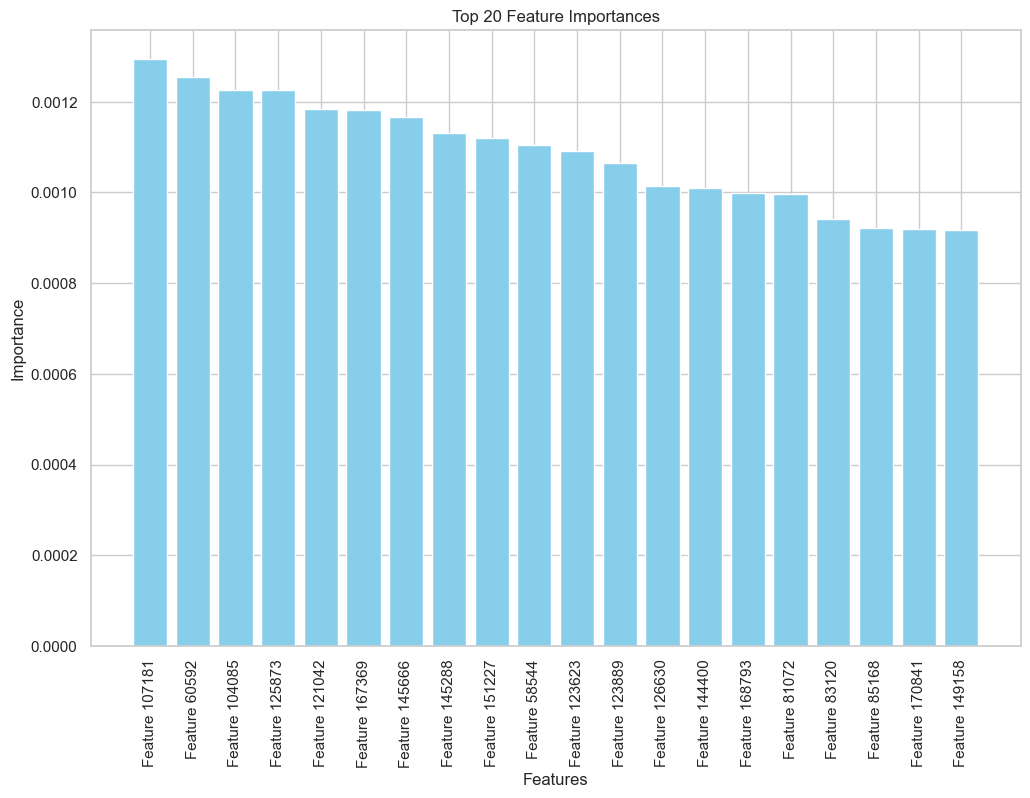

In [137]:
# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Rearrange feature importances
sorted_importances = importances[indices]

# Create labels for the most important features
labels = [f"Feature {i+1}" for i in indices]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.bar(labels[:20], sorted_importances[:20], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances')
plt.xticks(rotation=90)
plt.show()

The feature importances derived from Random Forest when used in conjunction with the feature extractor, ResNet50, are often opaque and abstract. Understanding what these features represent requires advanced analysis techniques such as activation mapping (e.g., Grad-CAM), filter visualization, or dimensionality reduction methods like PCA or t-SNE. These methods can provide insights into the specific aspects of input images that influence model decisions. However, due to the complexity and resource-intensive nature of these techniques, we have decided not to pursue further exploration in this area for our current project. Instead, we will focus our efforts on other aspects of model tuning and performance improvement that offer more immediate and clear benefits.

#### 5.2.4 Analyse the errors

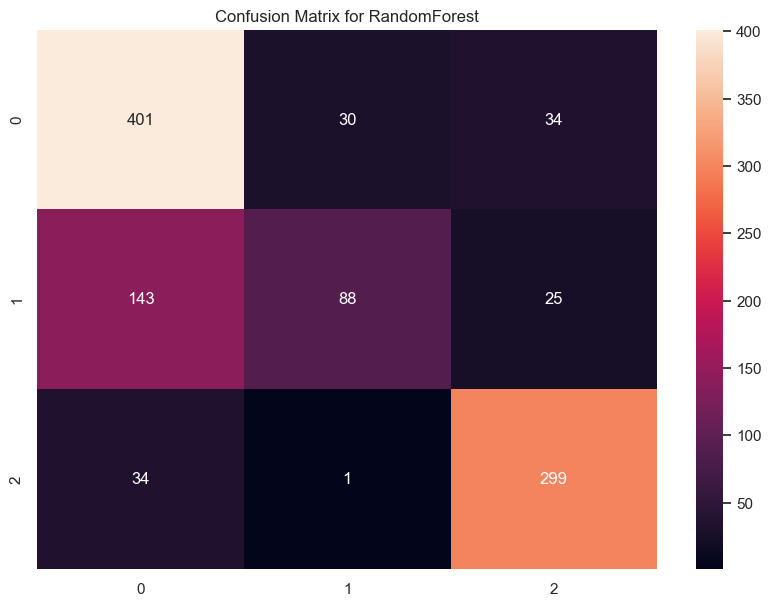

In [138]:
# Confusion Matrix 
cm_rf = confusion_matrix(val_labels, val_predictions_rf)
plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt="d")
plt.title('Confusion Matrix for RandomForest')
plt.show()

<h5>Observations</h5>
Class 0 (Fruit): was classified correctly 401 times

Class 1 (Vegetables): was classified correctly 88 times

Class 2 (Packages): was classified correctly 299 times


Fruit misclassified as Vegetable (30 times) and Packages (34 times) 

Vegetable misclassified as Fruit (143 times) and Packages (25 times)

Packages misclassified as Fruit (34 times) and Vegetable (1 times)



#### 5.2.5 A bit of feature engineering

Let's try this approach:
- PCA: Let's implement PCA on the ResNet50 outputs. The outputted data is high-dimensional feature vectors. Flattening the 3D arrays might result in a very large feature space, which can lead to overfitting or poor generalization, especially for underrepresented classes like vegetables.
- Class Weights: Since the vegetables class is underperforming, we will try to assign higher weights to the vegetable class in the random forest. Hopefully, it'll help the model focus more on correctly classifying vegetables.

We also observed that the vegetables get misclassified the most which could be due to the uneven distribution of the classes in the training dataset. The classes are represented as following: 1736 fruit samples, 1028 packages samples, 776 vegetables. 

In [140]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # You can adjust n_components based on the performance and computational resources
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)

# Compute class weights to handle imbalanced classes - vegetables are highly underrepresented
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))


# Initialize the RandomForest classifier
rf_model_improved_vol2 = RandomForestClassifier(n_estimators=150)

# Initialize variables for tracking the best performance
best_classification_report = None
best_iteration = 0
no_improve_count = 0

# Specify the maximum number of iterations without improvement
max_no_improve = 3

# Apply sample_weight by fetching the correct weight for each sample based on its class label
sample_weights = np.array([class_weight_dict[label] for label in train_labels])

# Train the model once
rf_model_improved_vol2.fit(train_features_pca, train_labels, sample_weight=sample_weights)

# Make predictions on the validation set
val_predictions_rf_vol2 = rf_model_improved_vol2.predict(val_features_pca)

# Get the classification report
classification_report_rf_vol2 = classification_report(val_labels, val_predictions_rf_vol2)

# Print the classification report
print(f"Classification report:\n{classification_report_rf_vol2}")


Classification report:
              precision    recall  f1-score   support

           0       0.66      0.89      0.76       465
           1       0.84      0.21      0.34       256
           2       0.81      0.87      0.84       334

    accuracy                           0.72      1055
   macro avg       0.77      0.66      0.64      1055
weighted avg       0.75      0.72      0.68      1055



Well, this was rather underwhelming. Balancing the classes with class weights did not work. It made the performance on vegetables worse (from 47% f1 to 36% max). And the recall also decreased (from 34% to 21%).

These are the potential issues:
- <b>Class Weights Impact</b>:
Class weights help balance underrepresented classes but might lead to overfitting the model to those classes, which can reduce its generalization ability. In this case, the model may have become too cautious in predicting vegetables, even though their precision is acceptable, leading to a low recall because it's only predicting vegetables in very obvious cases and missing others.

- <b>Overcompensating with Weights</b>:
When class weights are applied, it increases the model's focus on the vegetable class, but if the weight is too high, it could cause underfitting. The model may not be able to properly generalize to less obvious examples of vegetables, leading to poor recall despite relatively high precision.

- <b>Overfitting to Certain Features</b>:
Since the model is focusing too much on the vegetable class (due to the class weights), it might be overfitting to certain features that define vegetables well (improving precision) but missing out on less distinct features (reducing recall).

- <b>Vegetable Class Complexity</b>:
Vegetables might inherently be more difficult to classify due to visual similarity with other classes or subtle variations in appearance (e.g., different types of vegetables). Classifying vegetables may require more fine-grained feature learning, which the model might not be picking up effectively, even after adjusting the class weights.


<b>Conclusion</b>: We will not be spending time on more feature engineering for the random forest as the SVM seems more promising.

In [ ]:
# NOTE: XGB Classifier takes 20+ minutes with images of size 224x224 pixels compared to Random Forrest which takes a couple of minutes
# And the performance is not that different. So make sure to run this only if the previous image preprocessing is done with 150x150 pixels,
# Else you'll wait forever.
# This is also the reason why we did not explore the performance further.
# Initialize and train an XGBClassifier
xgb_model = XGBClassifier(n_estimators=100)
xgb_model.fit(train_features, train_labels)
print("XGBoost training completed.")
# Predict on validation set and print the classification report
val_predictions_xgb = xgb_model.predict(val_features)
# Calculate and print the accuracy
print(classification_report(val_labels, val_predictions_xgb))

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x0000020BABAA2710>>
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\xgboost\core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


### 5.3 Support Vector Machines (SVMs)

In [ ]:
# Using pretrained CNN for feature extraction (ResNet50 without the top classification layer)
feature_extractor = ResNet50(weights="imagenet", include_top=False, pooling='avg', input_shape=(348, 348, 3))

In [ ]:
# Function to extract features from a dataset directory
def extract_features_and_labels(directory, image_size=(348, 348), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values
    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',  
        shuffle=False
    )

    features = feature_extractor.predict(generator, verbose=1)  # features
    labels = generator.classes  # labels
    return features, labels

In [ ]:
train_dir = "GroceryStoreDataset-working/dataset/train"
val_dir = "GroceryStoreDataset-working/dataset/val"

X_train, y_train = extract_features_and_labels(train_dir)
X_val, y_val = extract_features_and_labels(val_dir)

# Combine training and validation
X = np.vstack((X_train, X_val))
y = np.hstack((y_train, y_val))



Found 2640 images belonging to 3 classes.


c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step
Found 296 images belonging to 3 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step


In [ ]:
# SVM pipeline
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler()),               
    ('classifier', SVC(kernel='linear', C=1))    
])

# Train pipeline
svm_pipeline.fit(X_train, y_train)

val_predictions = svm_pipeline.predict(X_val)
print("Validation Report:")
print(classification_report(y_val, val_predictions))



Validation Report:
              precision    recall  f1-score   support

           0       0.56      0.76      0.64       111
           1       0.89      0.66      0.76       100
           2       0.40      0.34      0.37        85

    accuracy                           0.60       296
   macro avg       0.62      0.59      0.59       296
weighted avg       0.63      0.60      0.60       296



#### 5.3.2  Analyze the most significant variables 

* SVMs do not assign weights or coefficients to individual features that directly indicate their importance.

#### 5.3.3 Analyze the types of errors the model makes

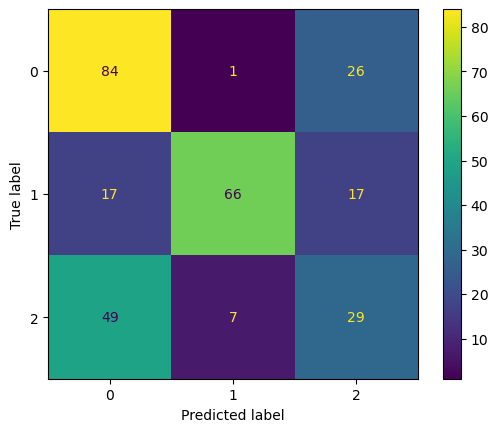

In [ ]:
cm = confusion_matrix(y_val, val_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

The SVM performs well for Class 0 and moderately well for Class 1 but struggles significantly with Class 2.
* Correct Predictions: 84 instances were correctly classified as Class 0.
* Correct Predictions: 66 instances were correctly classified as Class 1.
* Correct Predictions: 29 instances were correctly classified as Class 2.


#### 5.3.5 quick round of feature selection and engineering
 
In order to reduce noise and improve SVM performance dimensionality reduction using PCA (Principal Component Analysis) will be applied.

In [ ]:
# PCA to reduce dimensions
pca = PCA(n_components=100)  
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# SVM pipeline
svm_pipeline_pca = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler()),              
    ('classifier', SVC(class_weight='balanced'))    
])

# Train  pipeline 
svm_pipeline_pca.fit(X_train_pca, y_train)

# Validate 
val_predictions_pca = svm_pipeline_pca.predict(X_val_pca)
print("Validation Report (PCA Reduced Features):")
print(classification_report(y_val, val_predictions_pca))



Validation Report (PCA Reduced Features):
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       111
           1       0.77      0.92      0.84       100
           2       0.62      0.39      0.48        85

    accuracy                           0.71       296
   macro avg       0.69      0.69      0.68       296
weighted avg       0.69      0.71      0.69       296



The model has an overall accuracy of 70%, with strong performance on Class 1 but struggles with Class 2.

## 6. Fine-tune the system
### 6.1 Fine-tune the hyperparameters

Optimizing the SVM model using hyperparameter tuning  while also using the PCA-reduced dataset.

In [ ]:
# PCA for Dimensionality Reduction
explained_variance = 0.95  # Capture 95% of the variance
pca = PCA(n_components=explained_variance)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

print(f"Number of PCA components: {pca.n_components_}")

# SVM pipeline
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler()),                # Standardize features
    ('classifier', SVC(class_weight='balanced'))                       
])

# parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.5, 1, 2, 5, 10],        # Focus around the best C
    'classifier__gamma': [0.005, 0.01, 0.05],  # Smaller gamma range
    'classifier__kernel': ['rbf']
}

# hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)  # Train on PCA-reduced training data

print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on val data
best_svm_pipeline = grid_search.best_estimator_  # Retrieve the best pipeline
val_predictions = best_svm_pipeline.predict(X_val_pca)

# Classification report for validation data
print("Validation Report:")
print(classification_report(y_val, val_predictions))

Number of PCA components: 26
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters: {'classifier__C': 5, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Validation Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       111
           1       0.79      0.74      0.76       100
           2       0.65      0.52      0.58        85

    accuracy                           0.69       296
   macro avg       0.69      0.68      0.68       296
weighted avg       0.70      0.69      0.69       296



Plotting the confusion matrix again to compare

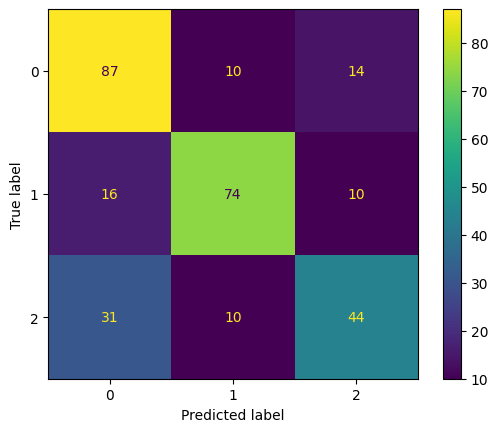

In [ ]:
cm = confusion_matrix(y_val, val_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Support Vector Machines (SVMs) are classical machine learning models that can achieve good results in structured data tasks or small feature spaces. 

SVM (Support Vector Machine) is the best fit for our dataset because it effectively handles high-dimensional feature spaces, especially after feature extraction with ResNet50 and PCA. The model balances precision and recall across classes, improving performance for underrepresented categories like "Vegetables." The ability to incorporate class weights further enables SVM to address class imbalance, ensuring fairer predictions. Given its robust generalization capabilities and the improvements seen on validation data, we are confident in applying SVM to the test data for reliable classification results.

### 6.2 Final model
This is the final run of our model on the test dataset.


In [ ]:
test_dir = "GroceryStoreDataset-working/dataset/test" 

X_test, y_test = extract_features_and_labels(test_dir)


Found 2485 images belonging to 3 classes.
78/78 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step


In [ ]:
# PCA Transformation
X_test_pca = pca.transform(X_test)

# Predictions Using the Best SVM Pipeline
test_predictions = best_svm_pipeline.predict(X_test_pca)

# Map Predictions to Class Labels
class_indices = {'Fruit': 0, 'Packages': 1, 'Vegetables': 2}    # Class-to-index mapping used in the training ImageDataGen generator
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse mapping

predicted_labels = [index_to_class[pred] for pred in test_predictions]

# DataFrame for predictions
# Read the file paths from test.txt
filenames = []
with open('GroceryStoreDataset-working/dataset/test.txt', 'r') as f:
    filenames = [line.strip() for line in f.readlines() if line.strip()]

# Check the length of filenames and predicted_labels
print(f"Length of filenames: {len(filenames)}")
print(f"Length of predicted_labels: {len(predicted_labels)}")

Length of filenames: 2485
Length of predicted_labels: 2485


In [ ]:
# DataFrame for predictions
results = pd.DataFrame({"Filename": filenames, "Predicted Class": predicted_labels})

# Save to CSV file
results.to_csv("svm_test_predictions.csv", index=False)
print("Test Predictions:")
print(results.head())

# Calculate Class Distribution Percentages
class_counts = results['Predicted Class'].value_counts(normalize=True) * 100  # Normalize=True gives percentages

print("Predicted Class Distribution Percentages:")
print(class_counts)

results.to_csv("predicted_class_distribution.csv", index=False)

print("\nSaved predictions and class distribution percentages to 'predicted_class_distribution.csv'")


Test Predictions:
                                            Filename Predicted Class
0  test/Fruit/Apple/Golden-Delicious/Golden-Delic...           Fruit
1  test/Fruit/Apple/Golden-Delicious/Golden-Delic...           Fruit
2  test/Fruit/Apple/Golden-Delicious/Golden-Delic...           Fruit
3  test/Fruit/Apple/Golden-Delicious/Golden-Delic...           Fruit
4  test/Fruit/Apple/Golden-Delicious/Golden-Delic...           Fruit
Predicted Class Distribution Percentages:
Predicted Class
Fruit         42.414487
Packages      33.400402
Vegetables    24.185111
Name: proportion, dtype: float64

Saved predictions and class distribution percentages to 'predicted_class_distribution.csv'


## 7. Conclussion